# Quelle est l'empreinte écologique de notre assiette ?

## *Traitement des données "Agribalyse"*

*Camille Gaborieau, Jérome Pivard et Blanche Lalouette*

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"


>##### Quels sont les effets environnementaux des produits que nous consommons ? ##### 

*Pour y répondre, nous allons partir des aliments qui constituent la plupart de nos repas. A partir de premières analyses des données Agribalyse (base de données produite par l’ADEME), nous concentrerons nos recherches sur les ingrédients les plus néfastes, puis nous remonterons à leur cycle de vie (de l’assiette au supermarché, de la mise en rayon à l’agriculture) et enfin, nous ferons le lien avec les méthodes agricoles soutenant la production alimentaire.*


## I/ RECUPERATION DES DONNEES ET NETTOYAGE DE LA BASE


### 1) Récupération des données


Nous avons récupéré 5 tableaux différents :

- df_synthese réunit les informations les plus importantes de tous les autres, en attribuant un score écologique à 2479 produits français
- df_ingredients rentre plus en détail sur les aliments composants les produits cités plus haut
- df_etapes retrace le chemin de nos ingrédients depuis l'agriculture jusqu'au supermarché
- df_agri_nonbio et df_agri_bio détaillent l'empreinte écologique due à l'agriculture respectivement non biologique et biologique des produits traitées dans les tableaux précédents.


In [2]:
df_synthese = pd.read_csv ("Agribalyse_Synthese.csv")
df_ingredients = pd.read_csv("Agribalyse_Detail ingredient.csv")
df_etapes = pd.read_csv("Agribalyse_Detail etape.csv")
df_agriculture = pd.ExcelFile("AGRIBALYSE3_partie agriculture.xlsx")
df_agri_1 = pd.read_excel(df_agriculture,"AGB_agri",header = 1)
df_agri_2 = pd.read_excel(df_agriculture, "AGB organic product", header=1)

En guise d'exemple, voici quelques informations sur notre premier tableau :

In [3]:
print(df_synthese[["Code AGB","Nom du Produit en Français","Groupe d'aliment","Sous-groupe d'aliment", "Saisonnalité", "Matériau d'emballage","Livraison","Préparation"]].nunique())

Code AGB                      2479
Nom du Produit en Français    2479
Groupe d'aliment                11
Sous-groupe d'aliment           58
Saisonnalité                     3
Matériau d'emballage            19
Livraison                        5
Préparation                     11
dtype: int64


Nos données regroupent ainsi  :
- 2479 aliments différents (qui ont bien tous un nom différent)
- 11 groupes et 55 sous-groupes d'aliments différents
- 3 types de saisonnalité
- Transport par avion est une variable indicatrice
- 5 modalités de livraison
- 11 types de préparation
- 19 matériaux d'emballage
- 14 indicateurs d'impact environnemental

### 2) Nettoyage des données

Procédons désormais à un nettoyage de nos tableaux. Il s'agit de retirer les valeurs manquantes, enlever les colonnes inutiles (nom anglais des produits, inducateurs peu robustes), et renommer les colonnes de façon plus parlante.

#### a) Tableau de synthèse

Pour le nettoyage de cette base, nous avons pour le moment adopté deux approches différentes, et avons donc deux tableaux différents avec les mêmes données, nous verrons lequel sera le plus adapté ensuite aux traitements que nous ferons: un tableau extrêmement synthétique, et un tableau avec un nettoyage plus allégé.

In [4]:
df_synthese = df_synthese.dropna()
df_synthese.drop(['Code CIQUAL', 'LCI Name'], axis='columns', inplace=True)

In [5]:
#On ne garde que les données qui ont un DQR (data quality ratio)plus faible qu'un certain seuil (3 par exemple) car “La Commission Européenne recommande de la prudence dans l’utilisation des données avec des DQR supérieurs à 3. Dans la base de données AGRIBALYSE, 67 % des données ont un DQR jugé bon ou très bon (1 à 3).” Garder deux tiers des données est suffisant pour avoir des résultats intéressants et un champ assez étendu.
df_synthese = df_synthese [df_synthese["DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)"]<=3].copy()

#On peut ne garder que celle dépassant un certain seuil (par exemple 1) au niveau de l'impact (par exemple au sens de l'indicateur précédent qui est à la fois l'un des plus robustes et l'un des plus parlants), pour éviter de considérer des aliments dont l'impact est finalement assez faible. Avantage : plus synthétique / Inconvénient : Perte d'information (compensée par notre deuxième nettoyage "allégé" du même tableau)
df_synthese_tronque_impact = df_synthese[df_synthese['Changement climatique (kg CO2 eq/kg de produit)']>1].copy()

#On choisit de ne garder que trois indicateurs d'impact environnemental (parmi les plus robustes) pour faire les premiers calculs : changement climatique, acidification, appauvrissement de la couche d'ozone. De plus, le score unique (indicateur composite qui calcule un impact pondéré fonction de tous les indicateurs selon leurs robustesses respectives) garantit qu'il n'y a pas de perte d'information.
df_synthese_reduit_indicateurs = df_synthese_tronque_impact [["Groupe d'aliment","Sous-groupe d'aliment",'Nom du Produit en Français','Livraison',"Matériau d'emballage",'Préparation','Score unique EF (mPt/kg de produit)','Changement climatique (kg CO2 eq/kg de produit)',"Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)","Acidification terrestre et eaux douces (mol H+ eq/kg de produit)",'DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)']]

#On s'aperçoit qu'il y a des doublons dans les noms des produits, on aimerait ne garder qu'une seule ligne par produit de même appelation. On peut y remédier en s'assurant que chaque produit du tableau a par exemple une valeur différente d'impact sur le changement climatique (on aurait pu le faire aussi avec n'importe quel autre indicateur).
df_synthese_bref = df_synthese_reduit_indicateurs.drop_duplicates(subset = ['Changement climatique (kg CO2 eq/kg de produit)']).sort_values("Groupe d'aliment").reset_index(drop=True)
df_synthese_bref

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)
0,aides culinaires et ingrédients divers,sauces,Sauce au yaourt,Glacé,V (PVC),Pas de préparation,0.216034,1.671115,0.180870,0.014745,1.80
1,aides culinaires et ingrédients divers,sauces,"Sauce madère, préemballée",Glacé,V (PVC),Micro onde,0.547529,5.945247,0.244267,0.067336,1.96
2,aides culinaires et ingrédients divers,sauces,"Sauce au beurre blanc, préemballée",Glacé,V (PVC),Micro onde,0.662983,7.943381,0.383447,0.056562,2.18
3,aides culinaires et ingrédients divers,sauces,Sauce au chocolat,Ambiant (moyenne),V (PVC),Pas de préparation,0.559919,7.278909,0.385557,0.029329,2.16
4,aides culinaires et ingrédients divers,sauces,"Sauce au fromage pour risotto ou pâtes, préemb...",Glacé,V (PVC),Micro onde,0.400105,4.075038,0.259955,0.040451,1.76
...,...,...,...,...,...,...,...,...,...,...,...
722,"viandes, œufs, poissons",charcuteries,"Chair à saucisse, crue",Glacé,PS,Pas de préparation,1.241559,8.092488,0.706075,0.162518,2.80
723,"viandes, œufs, poissons",viandes cuites,"Cervelle, veau, cuite",Glacé,PS,Four,2.412753,26.607947,0.935005,0.250664,2.65
724,"viandes, œufs, poissons",viandes crues,"Cervelle, veau, crue",Glacé,PS,Pas de préparation,1.737415,19.366768,0.643276,0.182545,2.63
725,"viandes, œufs, poissons",charcuteries,Saucisson à l'ail,Glacé,PS,Four,1.463490,11.807401,0.746750,0.190981,2.36


In [6]:
#Procédons désormais au nettoyage plus allégé: 
df_synthese.drop(["Code AGB"], axis = "columns", inplace = True)

#on supprime les aliments ayant un DQR trop élevé (les données recueillies sont peu fiables, cf infra)
df_synthese = df_synthese[df_synthese["DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)"].between(1,3)]
df_synthese_long = df_synthese.sort_values("Score unique EF (mPt/kg de produit)", ascending=False)
#On a ainsi un deuxième tableau, beaucoup plus riche en informations mais qui a pour inconvénient d'être moins lisible. Les aliments sont classés en fonction de leur "score unique", i.e. de leur impact environnemental pondéré par indicateur.

df_synthese_long

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Saisonnalité,Transport par avion (1 : par avion),Livraison,Matériau d'emballage,Préparation,DQR - Note de qualité de la donnée (1 excellente ; 5 très faible),Score unique EF (mPt/kg de produit),...,Particules (E-06 disease inc./kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),Eutrophisation terreste (mol N eq/kg de produit),Eutrophisation eaux douces (E-03 kg P eq/kg de produit),Eutrophisation marine (E-03 kg N eq/kg de produit),Utilisation du sol (Pt/kg de produit),Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit),Épuisement des ressources eau (m3 depriv./kg de produit),Épuisement des ressources énergétiques (MJ/kg de produit),Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit)
26,"viandes, œufs, poissons",viandes cuites,"Agneau, selle, partie maigre, rôtie/cuite au four",mix de consommation FR,0.0,Glacé,PS,Four,2.65,6.085768,...,6.372366,0.945773,4.197721,3.219668,198.623230,5535.059700,481.595690,15.542101,129.238930,22.659410
20,"viandes, œufs, poissons",viandes cuites,"Agneau, gigot, braisé",mix de consommation FR,0.0,Glacé,PS,Four,2.65,6.085768,...,6.372366,0.945773,4.197721,3.219668,198.623230,5535.059700,481.595690,15.542101,129.238930,22.659410
8,"viandes, œufs, poissons",viandes cuites,"Agneau, collier, braisé ou bouilli",mix de consommation FR,0.0,Glacé,PS,Four,2.65,6.085768,...,6.372366,0.945773,4.197721,3.219668,198.623230,5535.059700,481.595690,15.542101,129.238930,22.659410
23,"viandes, œufs, poissons",viandes cuites,"Agneau, gigot, rôti/cuit au four",mix de consommation FR,0.0,Glacé,PS,Four,2.65,6.085768,...,6.372366,0.945773,4.197721,3.219668,198.623230,5535.059700,481.595690,15.542101,129.238930,22.659410
335,"viandes, œufs, poissons",autres produits à base de viande,Brochette d'agneau,mix de consommation FR,0.0,Glacé,PS,Four,2.80,6.070264,...,6.369150,0.945678,4.198274,3.199425,198.441300,5534.671900,480.118160,15.471749,125.755090,22.382021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,boissons,eaux,"Eau minérale Evian, embouteillée, non gazeuse,...",mix de consommation FR,0.0,Ambiant (moyenne),Déjà emballé - PET,Pas de préparation,2.97,0.027756,...,0.012716,0.001140,0.002421,0.082969,0.223370,1.895194,3.266223,0.191489,6.472106,0.802522
738,boissons,eaux,"Eau de source Cristaline, embouteillée, non ga...",mix de consommation FR,0.0,Ambiant (moyenne),Déjà emballé - PET,Pas de préparation,2.97,0.027409,...,0.012670,0.001135,0.002411,0.082521,0.222256,1.891805,3.230392,0.190096,6.327958,0.796421
299,boissons,boissons sans alcool,Boisson préparée à partir de sirop à diluer ty...,mix de consommation FR,0.0,Ambiant (long),Bouteille PETE,Pas de préparation,2.95,0.019384,...,0.013471,0.001821,0.007219,0.031474,0.554482,3.312970,3.911030,0.417378,2.202102,0.416534
2337,boissons,boissons sans alcool,"Thé infusé, non sucré",mix de consommation FR,0.0,Ambiant (moyenne),LPDE,Cuisson à l'eau,2.98,0.014395,...,0.005310,0.000565,0.002058,0.021628,0.274376,3.953199,2.471866,0.637489,2.059509,0.144529


#### b) Tableau sur les ingrédients

Pour ce tableau, on n'a pas d'information sur la qualité des données. Cette fois, *on garde un maximum de données* (même si l'impact de l'ingrédient est faible) afin d'obtenir la décomposition la plus fine possible de l'impact environnemental du produit, en fonction des différents ingrédients et au sens des différents indicateurs (on ne garde que les plus robustes comme précédemment, sachant que le score unique contient toute l'information).

In [7]:
df_ingredients = df_ingredients.dropna()
df_ingredients.drop(['Ciqual AGB', 'LCI Name'], axis='columns', inplace=True)
df_ingredients = df_ingredients [['Ingredients','Nom Français',"Groupe d'aliment","Sous-groupe d'aliment",'Score unique EF (mPt/kg de produit)','Changement climatique (kg CO2 eq/kg de produit)',"Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)","Acidification terrestre et eaux douces (mol H+ eq/kg de produit)"]]
df_ingredients.head(5)

,Ingredients,Nom Français,Groupe d'aliment,Sous-groupe d'aliment,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit)
0,Jaune d'œuf,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.039743,0.164754,0.014089,0.006761
1,Ail,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.004417,0.011444,0.002512,0.000105
2,Jus de citron,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.019375,0.061230,0.007842,0.000951
3,Huile d'olive,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.445364,1.161825,0.136467,0.021524
4,Autres étapes,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.080761,0.571172,0.126768,0.002630


#### c) Tableau sur les étapes du cycle de vie du produit

Le nettoyage est résolument similaire à celui du dataframe df_synthese. On commence d'abord par enlever les données manquantes et les colonnes redondantes du dataframe. En particulier, les dernières colonnes détaillent la construction du DQR global, ce qui n'est pas primordial pour le traitement que nous souhaitons faire des données.

In [8]:
df_etapes = df_etapes.dropna()
df_etapes.drop(["Code CIQUAL", "LCI Name", "Groupe d'aliment", "Nom et code","DQR - P", "DQR - TiR", "DQR - GR", "DQR - TeR"], axis='columns', inplace=True)

#On remarque que les indicateurs précédemment triés se séparent entre six catégories correspondant aux six étapes du cycle de vie des aliments étudiés. Afin de pouvoir exploiter le dataframe, nous le simplifions en ne gardant que les scores uniques correspondant à chaque étape, et en créant un score unique moyen (regroupant toutes les étapes, mais sans pondération des étapes pour simplifier).Nous ne conservons ainsi que le dataframe contenant les éléments essentiels de présentation des aliments ainsi que ces indicateurs synthétiques.
df_etapes["Score unique EF (mPt / kg de produit)-Moyenne"] = (df_etapes["Score unique EF (mPt / kg de produit) - Agriculture"] + df_etapes["Score unique EF (mPt / kg de produit) - Transformation"] + df_etapes["Score unique EF (mPt / kg de produit) - Emballage"] + df_etapes["Score unique EF (mPt / kg de produit) - Transport"] + df_etapes["Score unique EF (mPt / kg de produit) - Supermarché et distribution"] + df_etapes["Score unique EF (mPt / kg de produit) - Consommation"])/6
df_etapes = df_etapes[["Sous-groupe d'aliment",'Nom du Produit en Français',"Score unique EF (mPt / kg de produit)-Moyenne", "Score unique EF (mPt / kg de produit) - Agriculture", "Score unique EF (mPt / kg de produit) - Transformation", "Score unique EF (mPt / kg de produit) - Emballage", "Score unique EF (mPt / kg de produit) - Transport","Score unique EF (mPt / kg de produit) - Supermarché et distribution", "Score unique EF (mPt / kg de produit) - Consommation","DQR"]]

#A nouveau, on ne garde que les données qui ont un DQR (data quality ratio) plus faible que 3 (voir supra pour la justification du seuil).
df_etapes = df_etapes[df_etapes["DQR"]<=3].copy()

#De même, nous supprimons les doublons dans les noms des produits afin de conserver qu'une seule ligne par produit de même appellation (on s'assure que chaque produit du tableau a une valeur différente de score unique).
df_etapes = df_etapes.drop_duplicates(subset = ['Score unique EF (mPt / kg de produit)-Moyenne'])

#Finalement, nous classons comme précédemment les données en fonction du sous-groupe d'aliment. 
df_etapes = df_etapes.sort_values("Sous-groupe d'aliment", ascending = True).copy()
df_etapes = df_etapes.reset_index(drop=True)
df_etapes.head(5)

,Sous-groupe d'aliment,Nom du Produit en Français,Score unique EF (mPt / kg de produit)-Moyenne,Score unique EF (mPt / kg de produit) - Agriculture,Score unique EF (mPt / kg de produit) - Transformation,Score unique EF (mPt / kg de produit) - Emballage,Score unique EF (mPt / kg de produit) - Transport,Score unique EF (mPt / kg de produit) - Supermarché et distribution,Score unique EF (mPt / kg de produit) - Consommation,DQR
0,aides culinaires,"Préparation culinaire à base de soja, type ""cr...",0.031080,0.094796,0.049300,0.016462,0.016024,0.009899,0.000000,2.09
1,algues,"Kombu ou kombu japonais (Laminaria japonica), ...",0.210055,0.667595,0.532574,0.022225,0.019454,0.017959,0.000522,2.99
2,algues,"Agar (algue), cru",0.208762,0.667595,0.532574,0.022225,0.019454,0.010205,0.000522,2.99
3,autres matières grasses,"Lard gras, cru",0.033827,0.145793,0.015529,0.015547,0.014042,0.009620,0.002429,2.11
4,autres matières grasses,Graisse de canard,0.033433,0.142160,0.016160,0.015547,0.014683,0.009620,0.002429,2.96


#### d) Données sur les produits bruts

On s'aperçoit qu'il y a un décalage dans les premières lignes, on va donc supprimer la ligne en trop (avec les noms des unités, que l'on reporte dans la première ligne). Enlevons toutes les colonnes inutiles avant de renommer les autres et de clarifier le décalage de lignes.

In [9]:
df_agri_normal= pd.read_excel(df_agriculture,"AGB_agri", header=1)

df_agri_normal.drop(['Unnamed: 1', 'Climate change - fossil', 'Climate change - biogenic','Climate change - land use and transform.'], axis='columns', inplace=True)
df_agri_nonbio = df_agri_normal.rename(columns={'Unnamed: 0':'Nom du produit', 'Unnamed: 2':'Catégorie', 'Climate change': 'Changement climatique (en eq. kg CO2)', 'Ozone depletion': 'Appauvrissement de la couche d ozone (en eq. kg CFC11)','Ionising radiation, HH':'Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)', 'Photochemical ozone formation, HH':'Formation d ozone photochimique (en eq. kg NMVOC)', 'Respiratory inorganics':'Substances inorganiques respiratoires (incidence de maladie)', 'Acidification terrestrial and freshwater':'Acidification (eq. mol H+)', 'Eutrophication freshwater': 'Eutrophisation eau douce (en eq. kg P)', 'Eutrophication marine':'Eutrophisation marine (en eq. kg N)', 'Eutrophication terrestrial':'Eutrophisation terrestre (en eq. mol N)', 'Ecotoxicity freshwater':'Ecotoxicité d eau douce (en CTUe)', 'Land use': 'Usage des terres (en Pt)', 'Water scarcity':'Epuisement des ressources en eau (en m3 Eau)', 'Resource use, energy carriers': 'Epuisement des ressources énergétiques (en MJ)', 'Resource use, mineral and metals': 'Epuisement des ressources minéraux (en eq. kg Sb)'}).copy()

df_agri_nonbio.drop([0],inplace = True)

#Cependant, comme nous l'avons vu, certains indicateurs sont très peu robustes. Enlevons les de nos données.
df_agri_nonbio.drop(["Usage des terres (en Pt)","Ecotoxicité d eau douce (en CTUe)", "Epuisement des ressources énergétiques (en MJ)","Epuisement des ressources minéraux (en eq. kg Sb)", "Epuisement des ressources en eau (en m3 Eau)"], axis ="columns", inplace=True)

df_agri_nonbio.head(5)

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
1,"Poulet, Bleu Blanc Coeur, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.44744,1.11454e-07,0.170576,0.00462458,3.2014e-07,0.0472122,0.000409922,0.0121022,0.206126
2,"Poulet, conventionnel, départ ferme / FR U",Agricultural\Animal production\Avian\Transform...,1.87453,1.45069e-07,0.219829,0.00632978,3.38427e-07,0.0493909,0.000515423,0.011752,0.212471
3,"Poulet, Label Rouge, à la de la ferme / FR U",Agricultural\Animal production\Avian\Transform...,2.82659,2.12771e-07,0.282615,0.0088557,5.4779e-07,0.0800916,0.000695502,0.0192948,0.346505
4,"Poulet, moyenne nationale, à la de la ferme /...",Agricultural\Animal production\Avian\Transform...,1.99191,1.53468e-07,0.227954,0.00664452,3.64812e-07,0.0532605,0.000538273,0.0127541,0.229395
5,"Canard à rôtir, conventionnel, à la ferme / FR U",Agricultural\Animal production\Avian\Transform...,2.73995,1.77542e-07,0.259452,0.00804329,6.45601e-07,0.0940418,0.000629109,0.017566,0.411137


On procède exactement de la même manières pour les produits brut biologiques.

In [10]:
df_agri_organic= pd.read_excel(df_agriculture,"AGB organic product", header=1)
df_agri_organic.drop(['Unnamed: 1', 'Climate change - fossil', 'Climate change - biogenic', 'Climate change - land use and transform.'], axis ="columns", inplace= True )
df_agri_bio = df_agri_organic.rename(columns={'Unnamed: 0':'Nom du produit', 'Unnamed: 2':'Catégorie', 'Climate change': 'Changement climatique (en eq. kg CO2)', 'Ozone depletion': 'Appauvrissement de la couche d ozone (en eq. kg CFC11)','Ionising radiation, HH':'Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)', 'Photochemical ozone formation, HH':'Formation d ozone photochimique (en eq. kg NMVOC)', 'Respiratory inorganics':'Substances inorganiques respiratoires (incidence de maladie)', 'Acidification terrestrial and freshwater':'Acidification (eq. mol H+)', 'Eutrophication freshwater': 'Eutrophisation eau douce (en eq. kg P)', 'Eutrophication marine':'Eutrophisation marine (en eq. kg N)', 'Eutrophication terrestrial':'Eutrophisation terrestre (en eq. mol N)', 'Ecotoxicity freshwater':'Ecotoxicité d eau douce (en CTUe)', 'Land use': 'Usage des terres (en Pt)', 'Water scarcity':'Epuisement des ressources en eau (en m3 Eau)', 'Resource use, energy carriers': 'Epuisement des ressources énergétiques (en MJ)', 'Resource use, mineral and metals': 'Epuisement des ressources minéraux (en eq. kg Sb)'}).copy()
df_agri_bio.drop([0], inplace = True)
df_agri_bio.drop(["Usage des terres (en Pt)","Ecotoxicité d eau douce (en CTUe)", "Epuisement des ressources énergétiques (en MJ)","Epuisement des ressources minéraux (en eq. kg Sb)", "Epuisement des ressources en eau (en m3 Eau)"], axis ="columns", inplace=True)

df_agri_bio.head(5)

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
1,"Poulet, biologique, à la ferme / FR U",Agricultural\Animal production\Avian\Transform...,2.50144,2.00028e-07,0.338122,0.00865668,5.90742e-07,0.0865018,0.000763565,0.0311399,0.380357
2,"Poulet, biologique, système n ° 1, à la ferme ...",Agricultural\Animal production\Avian\Transform...,3.36722,2.23134e-07,0.370369,0.00973865,6.40683e-07,0.0967691,0.00110792,0.0358753,0.41902
3,"Poulet, biologique, système n ° 2, à la ferme ...",Agricultural\Animal production\Avian\Transform...,3.35622,2.19161e-07,0.346624,0.00997517,6.26829e-07,0.095043,0.00112005,0.0373553,0.411431
4,"poule Réforme, porte biologique, à la ferme / ...",Agricultural\Animal production\Avian\Transform...,4.92108,4.28126e-07,0.878833,0.0134483,8.59302e-07,0.12478,0.00104827,0.0239226,0.536996
5,"Réforme poule, biologique, système n ° 1, à la...",Agricultural\Animal production\Avian\Transform...,9.14596,7.24577e-07,1.27946,0.0284353,2.1249e-06,0.309146,0.00228231,0.0577689,1.34246


## II/ TRAITEMENTS SUR LES DONNEES ET DATA VISUALISATION

### 1) Tableau de synthèse très synthétique

#### a) Statistiques toutes familles de produits confondues

On commence par faire quelques statistiques descriptives sur les données, afin d'avoir une idée de l'impact environnemental des produits considérés

In [10]:
df_synthese_bref.mean()

Score unique EF (mPt/kg de produit)                                      0.785731
Changement climatique (kg CO2 eq/kg de produit)                          7.128661
Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)    0.773740
Acidification terrestre et eaux douces (mol H+ eq/kg de produit)         0.090091
DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)        2.484525
dtype: float64

On obtient l'impact environnemental moyen sur tous les produits, qui servira de référence pour comparer l'impact de certains produits particuliers. 
>La *moyenne la plus significative est le score unique moyen*, qui prend en compte tous les indicateurs et les pondère selon leur robustesse, ce score moyen est de 0,79 environ. 

> Notons que le *DQR moyen est proche de 2,5* : cela signifie que les données conservées sont en moyenne assez fiables (on vérifiera quand même plus loin que les éventuelles différences de DQR ne biaisent pas nos résultats).

Ne nous limitons pas à la moyenne et regardons les principales statistiques descriptives, sur le score unique seulement pour commencer.

,Score unique EF (mPt/kg de produit)
count,727.000000
mean,0.785731
std,0.905110
min,0.110970
25%,0.265143
50%,0.450487
75%,0.853604
max,6.085768


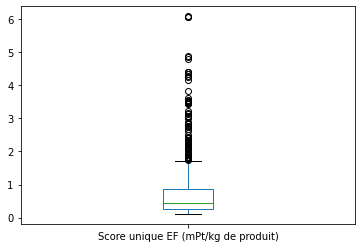

In [11]:
df_synthese_bref[["Score unique EF (mPt/kg de produit)"]].describe()
df_synthese_bref[["Score unique EF (mPt/kg de produit)"]].plot(kind="box")


Principaux constats :

- *Les scores moyens s'étendent de 0,11 à 6,09* : Il y a donc des aliments qui polluent largement plus que la moyenne (plus de sept fois plus que la moyenne pour le plus polluant) et d'autres beaucoup moins (idem, rapport relatif autour de 7).

- Les quartiles suggèrent que *la distribution n'est pas très régulière*,ce qu'illustre la boxplot précédente. En particulier, la médiane est nettement sous la moyenne (score médiane : à peine 60% du score moyen ), ce qui suggère que certaines valeurs extrêmes poussent la moyenne vers le haut. 

>*En d'autres termes,*
- *la moitié des produits ont un score unique inférieur à 0,45 (ce qui semble assez faible),* 
- *trois quarts ont un score unique inférieur à 0,85 (c'est-à-dire peu supérieur à la moyenne !)*
- *mais quelques aliments relativement très polluants tirent la moyenne vers le haut.*

In [13]:
df_synthese_bref[["Score unique EF (mPt/kg de produit)"]].quantile(q = [0.8,0.9,0.95])

,Score unique EF (mPt/kg de produit)
0.80,1.162601
0.90,1.203524
0.95,1.223986


##### On voit que seuls 5% des scores uniques sont au-dessus de 2,78 (i.e. un peu plus de trois fois le score moyen), cela confirme qu'un petit nombre d'aliments a un impact fort. Repérons les.

In [14]:
produits_fort_impact = df_synthese_bref[df_synthese_bref["Score unique EF (mPt/kg de produit)"]>2.78]
produits_fort_impact_classes = produits_fort_impact.sort_values('Score unique EF (mPt/kg de produit)',ascending = False)
produits_fort_impact_classes.reset_index(drop=True).head(16)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)



Sur les 37 aliments considérés, trois seulement ont un score unique supérieur à six (et largement supérieur aux suivants) et ils contiennent tous de l'agneau. Derrière on retrouve essentiellement des produits à base de viande, mais il y a aussi les deux exceptions, arrivant en 14ème et 16ème place (c'est-à-dire assez haut !).

Lorsque l'on y regarde de plus près, on voit que ces deux aliments sans viande impactent surtout l'environnement en contribuant à appauvrir la couche d'ozone (plus que les aliments avec viande qui ont surtout un indicateur "Changement climatique" élevé). Comparons d'ailleurs le classement précédent avec le classement en fonction de l'indicateur "appauvrissement de la couche d'ozone".

In [15]:
produits_fort_impact_classes_ozone = produits_fort_impact.sort_values("Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)",ascending = False)
produits_fort_impact_classes_ozone.reset_index(drop=True).head(16)


,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)


>Ce classement confirme l'hypothèse précédente, surtout pour les nouilles : c'est bien leur impact sur la couche d'ozone qui les propulse dans le haut du classement. 

Travailler avec les données des autres tableaux devrait permettre de comprendre quelle étape du cycle de vie du produit explique cet impact. Pour les pêches, c'est un peu moins net ; il serait donc intéressant de regarder les autres indicateurs.

###### Remarque : Pour voir à quel point les disparités en termes de DQR influent sur le score unique moyen (et donc sur l'impact environnemental observé), on aurait pu faire les mêmes statistiques en nous restreignant aux données les plus fiables (DQR inférieur au DQR moyen pour avoir assez de données i.e. à 2,5). Cela n'était en fait pas utile, car lorsqu'on regarde les aliments les plus polluants, on voit que les DQR sont fluctuants entre 2 et 3, ce qui suggère qu'il n'y a pas de biais dans la fiabilité des données pour les aliments à fort impact.

Regardons également rapidement les produits à faible impact (on ne s'y intéressera plus beaucoup ensuite, à part peut-être pour imaginer des repas plus "soutenables" sur le plan environnemental). Fixons le seuil à la moitié de la valeur médiane du score unique (soit environ 0,25). Attention : on n'avait retiré les aliments ayant le plus faible impact sur le changement climatique, donc il faut aussi regarder le tableau de synthèse plus complet.

In [16]:
produits_faible_impact = df_synthese_bref[df_synthese_bref["Score unique EF (mPt/kg de produit)"]<0.25].sort_values("Score unique EF (mPt/kg de produit)")
produits_faible_impact.head(5)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)



Cette fois, on s'aperçoit que les aliments à faible impact appartiennent à des groupes d'aliments assez variés, on va donc adopter une autre approche : comparer en classant par groupe d'aliment.

#### b) Statistiques sur des groupes d'aliments précis

L'idée de cette partie est de comparer l'impact environnemental d'aliments de la même famille, notamment dans le but de voir comment nous pouvons rendre nos repas plus respectueux de l'environnement (par substitution avec un aliment proche i.e. de la même famille).

In [17]:
df_synthese_familles=df_synthese_bref.copy()
df_synthese_familles.drop(["Changement climatique (kg CO2 eq/kg de produit)", "Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)","Acidification terrestre et eaux douces (mol H+ eq/kg de produit)", "DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)"], axis='columns', inplace=True)

#Commençons par effectuer les mêmes statistiques descriptives que tout à l'heure, mais pour chaque groupe d'aliment cette fois. On se concentre sur le score unique.
df_synthese_familles.groupby("Groupe d'aliment").describe()

Score unique EF (mPt/kg de produit)  \
                                                                          count   
Groupe d'aliment                                                                  
fruits, légumes, légumineuses et oléagineux                                 2.0   

                                                                          \
                                                 mean      std       min   
Groupe d'aliment                                                           
fruits, légumes, légumineuses et oléagineux  1.039832  0.28937  0.835217   

                                                                          \
                                                  25%       50%      75%   
Groupe d'aliment                                                           
fruits, légumes, légumineuses et oléagineux  0.937524  1.039832  1.14214   

                                                       
                                                  max  
Groupe d'aliment                                       
fruits, légumes, légumineuses et oléagineux  1.244447

Principales conclusions en comparant les différentes lignes :

- *Ce sont bien "viandes, oeufs et poissons" qui ont l'impact environnemental moyen le plus élevé,* et cette différence est nette avec toutes les autres catégories de produits, dans la mesure où le score unique moyen est plus de deux fois supérieur (1,72) à celui de la catégorie suivante. Il faudra néanmoins zoomer à l'intérieur de cette catégorie car l'écart-type est assez élevé (1,3), ce qui traduit d'importantes disparités.

- Ensuite viennent les produits sucrés (score unique moyen:0,77) et les "entrées et plats composés"(pas surprenant car contiennent souvent de la viande, score unique moyen : 0,71). Néanmoins, les scores ne sont pas distribués de la même manière dans ces deux catégories si l'on compare les différences entre médiane et moyenne respectives. Remarquons tout de même que la pertinence de la comparaison qui va suivre est à nuancer sachant qu'il y a beaucoup plus d'aliments dans la seconde catégorie que dans la première.

- D'une part, pour les produits sucrés (peu nombreux), la médiane et la moyenne sont proches, et le score maximal est à peine deux fois plus grand que le score moyen de cette catégorie (et plus faible que les scores max des autres catégories), ce qui signifie que les impacts environnementaux des produits de cette catégorie sont apparemment semblables.Une comparaison interne à ce groupe ne semble donc pas nécessaire pour répondre à notre problématique

- D'autre part, pour les plats composés et entrées, on a au contraire une plus forte dispersion des valeurs (qui sont bien plus nombreuses), dans la mesure où la médiane est bien inférieure à la moyenne du score unique et car le maximum est cette fois plus élevé. Hypothèse : on peut expliquer ces résultats par le fait que la plupart des aliments transformés en question contiennent de la viande, des oeufs ou du poisson ; qui ont un impact à la fois globalement plus élevé, mais aliments entre lesquels on trouve d'importants écarts en termes d'impacts.

>*Remarquons enfin que les familles d'aliments où l'impact moyen est le plus faible sont les suivantes : "fruits,légumes, légumineuses et oléagineux" et "lait et produits laitiers" (seules familles où le score moyen est sous 0,4).* 

Néanmoins, dans le cas de la première, les quantiles suggèrent que la distribution des valeurs est également dispersée, ce qui justifie également de zoomer à l'intérieur de cette catégorie.

Représentons graphiquement cette comparaison des scores moyens des différents groupes d'aliments. On en profite pour prendre en compte également les trois indicateurs que l'on a regardés (ainsi que DQR pour s'assurer que la qualité des données est comparable).

Text(0.5, 1.0, 'Comparaison des scores moyens des groupes d aliments')

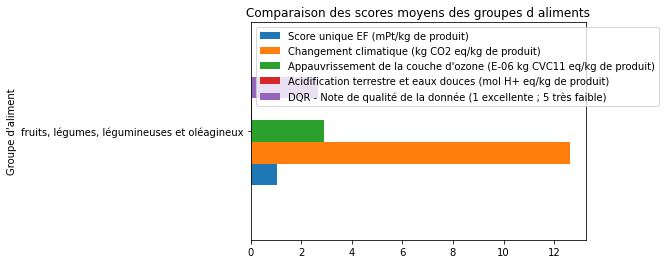

In [18]:
df_impact_moyens=df_synthese_bref.groupby("Groupe d'aliment").mean()
graph_impacts_moyens = df_impact_moyens.plot(kind="barh")
plt.title('Comparaison des scores moyens des groupes d aliments')

graph_impacts_moyens


Commentaire : En raison de son échelle, le graphique est surtout parlant pour comparer les groupes d'aliments en fonction de leur impact moyen sur le changement climatique (en orange). 
>Il en ressort nettement que "viandes,oeufs et poissons" sont largement devant (16.7), suivis par "produits sucrés", "matières grasses", puis "entrées et plats composés", alors que "fruits, légumes, légumineuses et oléagineux" ferment la marche.

En dehors des impacts sur le changement climatique, on remarque que :

- En termes d'appauvrissement de la couche d'ozone (en vert), c'est au contraire le groupe des "fruits,légumes, légumineuses et oléagineux" qui est largement devant tous les autres.
- La qualité des données (en violet) est semblable pour tous les groupes, ce qui justifie ces comparaisons.

###### D'après les analyses exploratoires précédentes, l'un des premiers leviers de réduction de l'impact environnemental de nos assiettes est donc de réduire la consommation de viandes ayant un fort impact et d'augmenter la consommation de fruits et légumes (en particulier ceux ayant un faible impact), ainsi que de produits laitiers. 

Comparons alors l'impact des différentes viandes et autres produits de la famille "viandes,oeufs,poisson" ainsi que celui des différents "fruits et légumes"pour voir comment faire concrètement.

In [19]:
df_synthese_groupe_impact_fort = df_synthese_bref[df_synthese_bref["Groupe d'aliment"] =="viandes, œufs, poissons"]
df_synthese_groupe_impact_fort.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).head(10)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)


>Au sein de cette famille, les produits à privilégier pour réduire l'impact environnemental de son assiette sont certaines viandes crues (poulet,porc...), certaines charcuteries, ou encore des plats à base d'oeufs comme la tortilla.

In [20]:
df_synthese_groupe_impact_fort = df_synthese_bref[df_synthese_bref["Groupe d'aliment"] =="viandes, œufs, poissons"]
df_synthese_groupe_impact_fort.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).tail(10)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)


>Au contraire, les aliments de cette famille qu'il faut éviter sont globalement les viandes cuites, et en particulier le boeuf et surtout l'agneau.

Voici quelques exemples de fruits ou légumes à privilégier : 

In [21]:
df_synthese_groupe_impact_faible = df_synthese_bref[df_synthese_bref["Groupe d'aliment"] =="fruits, légumes, légumineuses et oléagineux"]
df_synthese_groupe_impact_faible.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).head(5)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)
0,"fruits, légumes, légumineuses et oléagineux",légumes,"Haricot vert importé par avion, cru",Ambiant (moyenne),Pas d'emballage,Réfrigéré chez le consommateur,0.835217,10.316175,2.376467,0.055054,2.52
1,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue",Ambiant (moyenne),Pas d'emballage,Pas de préparation,1.244447,14.898319,3.418751,0.074669,2.79


>On retrouve alors : chou, courgette et carotte pour les légumes, ananas pour les fruits (mais la plupart sont des légumes, il n'y a pas beaucoup de fruits dans le bas du classement !). 

Pour en savoir plus sur les fruits, il faut grouper par sous-groupe (cf infra).

In [22]:
df_synthese_fruits = df_synthese_bref[df_synthese_bref["Sous-groupe d'aliment"] =="fruits"]
df_synthese_fruits.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).head(10)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)
0,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue",Ambiant (moyenne),Pas d'emballage,Pas de préparation,1.244447,14.898319,3.418751,0.074669,2.79


>Dans les fruits à privilégier, on retrouve notamment, avec un score unique inférieur à 0,3 :abricots au sirop, myrtille, banane et cassis crus...

Regardons alors les fruits et légumes à éviter 

In [23]:
df_synthese_groupe_impact_faible = df_synthese_bref[df_synthese_bref["Groupe d'aliment"] =="fruits, légumes, légumineuses et oléagineux"]
df_synthese_groupe_impact_faible.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).tail(5)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)
0,"fruits, légumes, légumineuses et oléagineux",légumes,"Haricot vert importé par avion, cru",Ambiant (moyenne),Pas d'emballage,Réfrigéré chez le consommateur,0.835217,10.316175,2.376467,0.055054,2.52
1,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue",Ambiant (moyenne),Pas d'emballage,Pas de préparation,1.244447,14.898319,3.418751,0.074669,2.79


> Les fruits et légumes à éviter (en fait, symétriquement, on a ici presque que des fruits, donc il faudra regarder ensuite par sous-groupe) sont la pêche (impact largement plus fort que les autres fruits comme on l'avait déjà remarqué), la tomate, le pruneau et la mangue pour les fruits ; oignon et haricots verts pour les légumes.

### 2) Tableau "moins synthétique"

Il est intéressant de revenir à un tableau plus riche en indicateurs afin d'affiner notre étude sur l'impact environnemental de notre alimentation

In [24]:
df_synthese_long = df_synthese_long.drop_duplicates(subset = ['Changement climatique (kg CO2 eq/kg de produit)'])
df_synthese_long.reset_index(drop=True).head(2)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,DQR - Note de qualité de la donnée (1 excellente ; 5 très faible),Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),...,Eutrophisation terreste (mol N eq/kg de produit),Eutrophisation eaux douces (E-03 kg P eq/kg de produit),Eutrophisation marine (E-03 kg N eq/kg de produit),Utilisation du sol (Pt/kg de produit),Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit),Épuisement des ressources eau (m3 depriv./kg de produit),Épuisement des ressources énergétiques (MJ/kg de produit),Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit),Saisonnalité,Transport par avion (1 : par avion)
0,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue",Ambiant (moyenne),Pas d'emballage,Pas de préparation,2.79,1.244447,14.898319,3.418751,...,0.274655,0.487313,24.256069,32.048403,206.260910,17.622634,218.49787,3.906755,mix de consommation FR,1.0
1,"fruits, légumes, légumineuses et oléagineux",légumes,"Haricot vert importé par avion, cru",Ambiant (moyenne),Pas d'emballage,Réfrigéré chez le consommateur,2.52,0.835217,10.316175,2.376467,...,0.205713,0.387346,19.106720,119.063840,83.567205,8.106421,154.41530,2.575316,mix de consommation FR,1.0


On va maintenant se concentrer que quelques aliments en particulier, et les décortiquer afin d'identifier des leviers de réduction de leur impact environnemental.

In [25]:
df_synthese_long[["Score unique EF (mPt/kg de produit)"]].describe()

,Score unique EF (mPt/kg de produit)
count,2.000000
mean,1.039832
std,0.289370
min,0.835217
25%,0.937524
50%,1.039832
75%,1.142140
max,1.244447


Pour rappel, nous avions un biais de sélection dans le premier tableau : nous n'avions conservé que les aliments ayant un impact significatif sur le changement climatique (supérieur à 1) afin de saisir les éléments qui ont un impact environnemental significatif. Si ce choix pouvait paraître arbitraire, le résultat précédent permet de le justifier.

En effet, en les conservant, nous remarquons que 
>*le score unique est plus faible (moyenne autour de 0,64)* : les éléments ayant un impact sur le changement climatique le plus faible tirent vers le bas le score unique ; ce sont donc également ceux qui polluent le moins en général. 

> la moyenne des indicateurs "Appauvrissement de la couche d'ozone" et "Acidification terrrestre et eaux douces" est également plus faible dans le tableau synthese plus riche (voir précédent). 

Nous pouvons donc supposer qu'ils sont les moins polluants de manière générale et peuvent être négligés dans notre étude pour l'instant. 

> De même, ceux qui ont un impact le plus faible en terme de changement climatique était également ceux qui ont en moyenne un DQR moyen plus élevé : ce sont également des données dont les indicateurs sont moins fiables que les autres aliments conservés.

###### Nos premières études peuvent donc être effectuées à partir du tableau synthese allégée.

Cependant, ce tableau synthèse avec davantage de critères permet de déterminer si le groupe d'aliments le plus polluant en général reste le plus polluant quand on se concentre que sur certains critères.

Regardons par exemple les aliments les plus polluants en terme d'acidification terrestre et eau douce 

In [26]:
df_synthese_acidification = df_synthese_long.sort_values("Acidification terrestre et eaux douces (mol H+ eq/kg de produit)",ascending = False)
df_synthese_acidification.head(5)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,DQR - Note de qualité de la donnée (1 excellente ; 5 très faible),Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),...,Eutrophisation terreste (mol N eq/kg de produit),Eutrophisation eaux douces (E-03 kg P eq/kg de produit),Eutrophisation marine (E-03 kg N eq/kg de produit),Utilisation du sol (Pt/kg de produit),Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit),Épuisement des ressources eau (m3 depriv./kg de produit),Épuisement des ressources énergétiques (MJ/kg de produit),Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit),Saisonnalité,Transport par avion (1 : par avion)
1355,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue",Ambiant (moyenne),Pas d'emballage,Pas de préparation,2.79,1.244447,14.898319,3.418751,...,0.274655,0.487313,24.256069,32.048403,206.260910,17.622634,218.49787,3.906755,mix de consommation FR,1.0
1141,"fruits, légumes, légumineuses et oléagineux",légumes,"Haricot vert importé par avion, cru",Ambiant (moyenne),Pas d'emballage,Réfrigéré chez le consommateur,2.52,0.835217,10.316175,2.376467,...,0.205713,0.387346,19.106720,119.063840,83.567205,8.106421,154.41530,2.575316,mix de consommation FR,1.0


Les viandes cuites se distiguent toujours des autres aliments comme étant particulièrement polluant.

Si quelques aliments peuvent dépasser ponctuellement les viandes en tête du classement des aliments les plus polluants en fonction des indicateurs proposés, le sous-groupe d'aliments des viandes cuites est systématiquement dans les premiers groupes d'aliments les plus impactant en terme d'environnement (le cas de l'épuisement des ressources en eau fait exception). Isolons donc ce sous-groupe groupe d'aliment :

In [27]:
df_synthese_viandes_cuites = df_synthese_long[df_synthese_long["Sous-groupe d'aliment"] == "viandes cuites"]
df_synthese_viandes_cuites.mean()-df_synthese_long.mean()


Acidification terrestre et eaux douces (mol H+ eq/kg de produit)           NaN
Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)      NaN
Changement climatique (kg CO2 eq/kg de produit)                            NaN
DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)          NaN
Eutrophisation eaux douces (E-03 kg P eq/kg de produit)                    NaN
Eutrophisation marine (E-03 kg N eq/kg de produit)                         NaN
Eutrophisation terreste (mol N eq/kg de produit)                           NaN
Formation photochimique d'ozone (E-03 kg NMVOC eq/kg de produit)           NaN
Groupe d'aliment                                                           NaN
Livraison                                                                  NaN
Matériau d'emballage                                                       NaN
Nom du Produit en Français                                                 NaN
Particules (E-06 disease inc./kg de produit)        

Ainsi, nous remarquons en calculant une différence des moyennes que tous les indicateurs pour les viandes cuites présentent des coefficients moyens supérieurs à ceux de l'ensemble des aliments : ce sont donc en général le sous-groupe d'aliment le plus polluant dans l'ensemble des catégories d'indicateurs. Nous pouvons le voir également avec les graphiques suivants graphiques suivant :

- le premier compare les scores uniques moyens des différents groupes d'aliments;
- le second précise l'impact de chacun selon les différents indicateurs.

Text(0.5, 1.0, 'Comparaison des scores uniques des groupes d aliments')

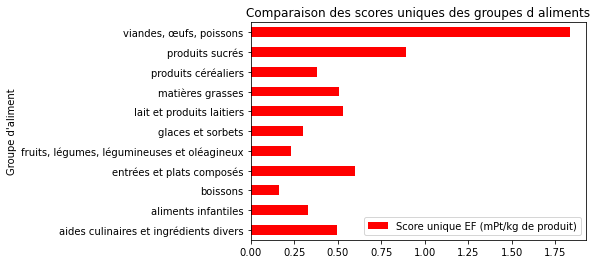

In [12]:
df_synthese_score_unique = df_synthese_long[["Groupe d'aliment", "Score unique EF (mPt/kg de produit)"]]
df_synthese_score_unique_graph = df_synthese_score_unique.groupby("Groupe d'aliment").mean().plot(kind="barh", color ='red', stacked = True)
plt.title('Comparaison des scores uniques des groupes d aliments')

On a bien la confirmation du classement effectué entre groupes d'aliments en fonction de leur score unique moyen. 


Text(0.5, 1.0, 'Comparaison de la part prise par chaque indicateur par groupe d aliments')

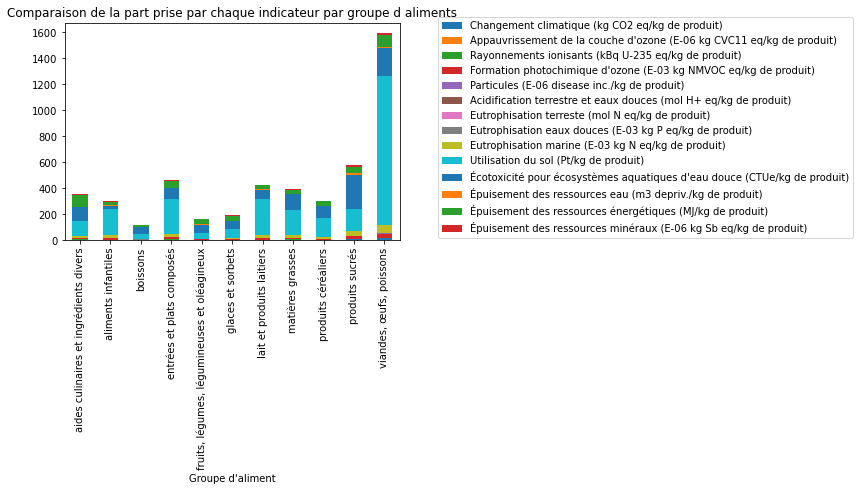

In [13]:
df_synthese_copy = df_synthese_long.copy()
df_synthese_copy.drop(["Score unique EF (mPt/kg de produit)", "DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)","Transport par avion (1 : par avion)"], axis = "columns",inplace=True)
df_synthese_moyenne_graph = df_synthese_copy.groupby("Groupe d'aliment").mean().plot(kind="bar", stacked = True).legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Comparaison de la part prise par chaque indicateur par groupe d aliments')

Ce graphique permet en plus une comparaison relative des niveaux pris par les différents indicateurs en fonction des groupes. Bien sûr, on ne peut comparer les indicateurs entre eux (pas les mêmes unités), mais cela nous donne tout de même quelques enseignements supplémentaires :

> L'utilisation du sol par "viandes, oeufs et poissons" est considérable si on la compare avec celle des autres groupes;

>Certains groupes ont des "profils" proches en terme d'importance relative des différents indicateurs dans leur impact environnemental (aides culinaires et produits sucrés par exemple), alors que d'autres sont très dissemblables (viandes et fruits/légumes par exemple).

Il serait intéressant de choisir un aliment parmi ses viandes cuites ou bien un plat à base de viandes cuites puis creuser l'origine de cet impact important sur l'environnement sur l'ensemble de ces indicateurs

Regardons maintenant les produits à faible impact (nous sélectionnons par exemple ceux étant dans le premier quartile du score unique) :

In [30]:
aliments_peu_polluants = df_synthese_long[df_synthese_long["Score unique EF (mPt/kg de produit)"]<0.178697].sort_values("Score unique EF (mPt/kg de produit)")
aliments_peu_polluants.head(10)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,DQR - Note de qualité de la donnée (1 excellente ; 5 très faible),Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),...,Eutrophisation terreste (mol N eq/kg de produit),Eutrophisation eaux douces (E-03 kg P eq/kg de produit),Eutrophisation marine (E-03 kg N eq/kg de produit),Utilisation du sol (Pt/kg de produit),Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit),Épuisement des ressources eau (m3 depriv./kg de produit),Épuisement des ressources énergétiques (MJ/kg de produit),Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit),Saisonnalité,Transport par avion (1 : par avion)



>En plus des fruits et des légumes à privilégier, les produits laitiers,tels que le yaourt, sont également des produits que nous pourrions qualifier de "propre".

*Nous allons maintenant tenter de zoomer sur certains produits à impact élevé, en décortiquant leur composition et en évaluant l'impact par ingrédient.*

### 3) Tableau sur les ingrédients

On va ici regarder en priorité les aliments transformés et cuisinés (ce que ce tableau permet de faire et pas les autres), et donc principalement appartenant la famille "entrées et plats composés" (qui arrive en deuxième position en termes d'impact global).

Text(0, 0.5, '')

Text(0.5, 1.0, 'Tirage aléatoire de produits transformés et impact environnemental')

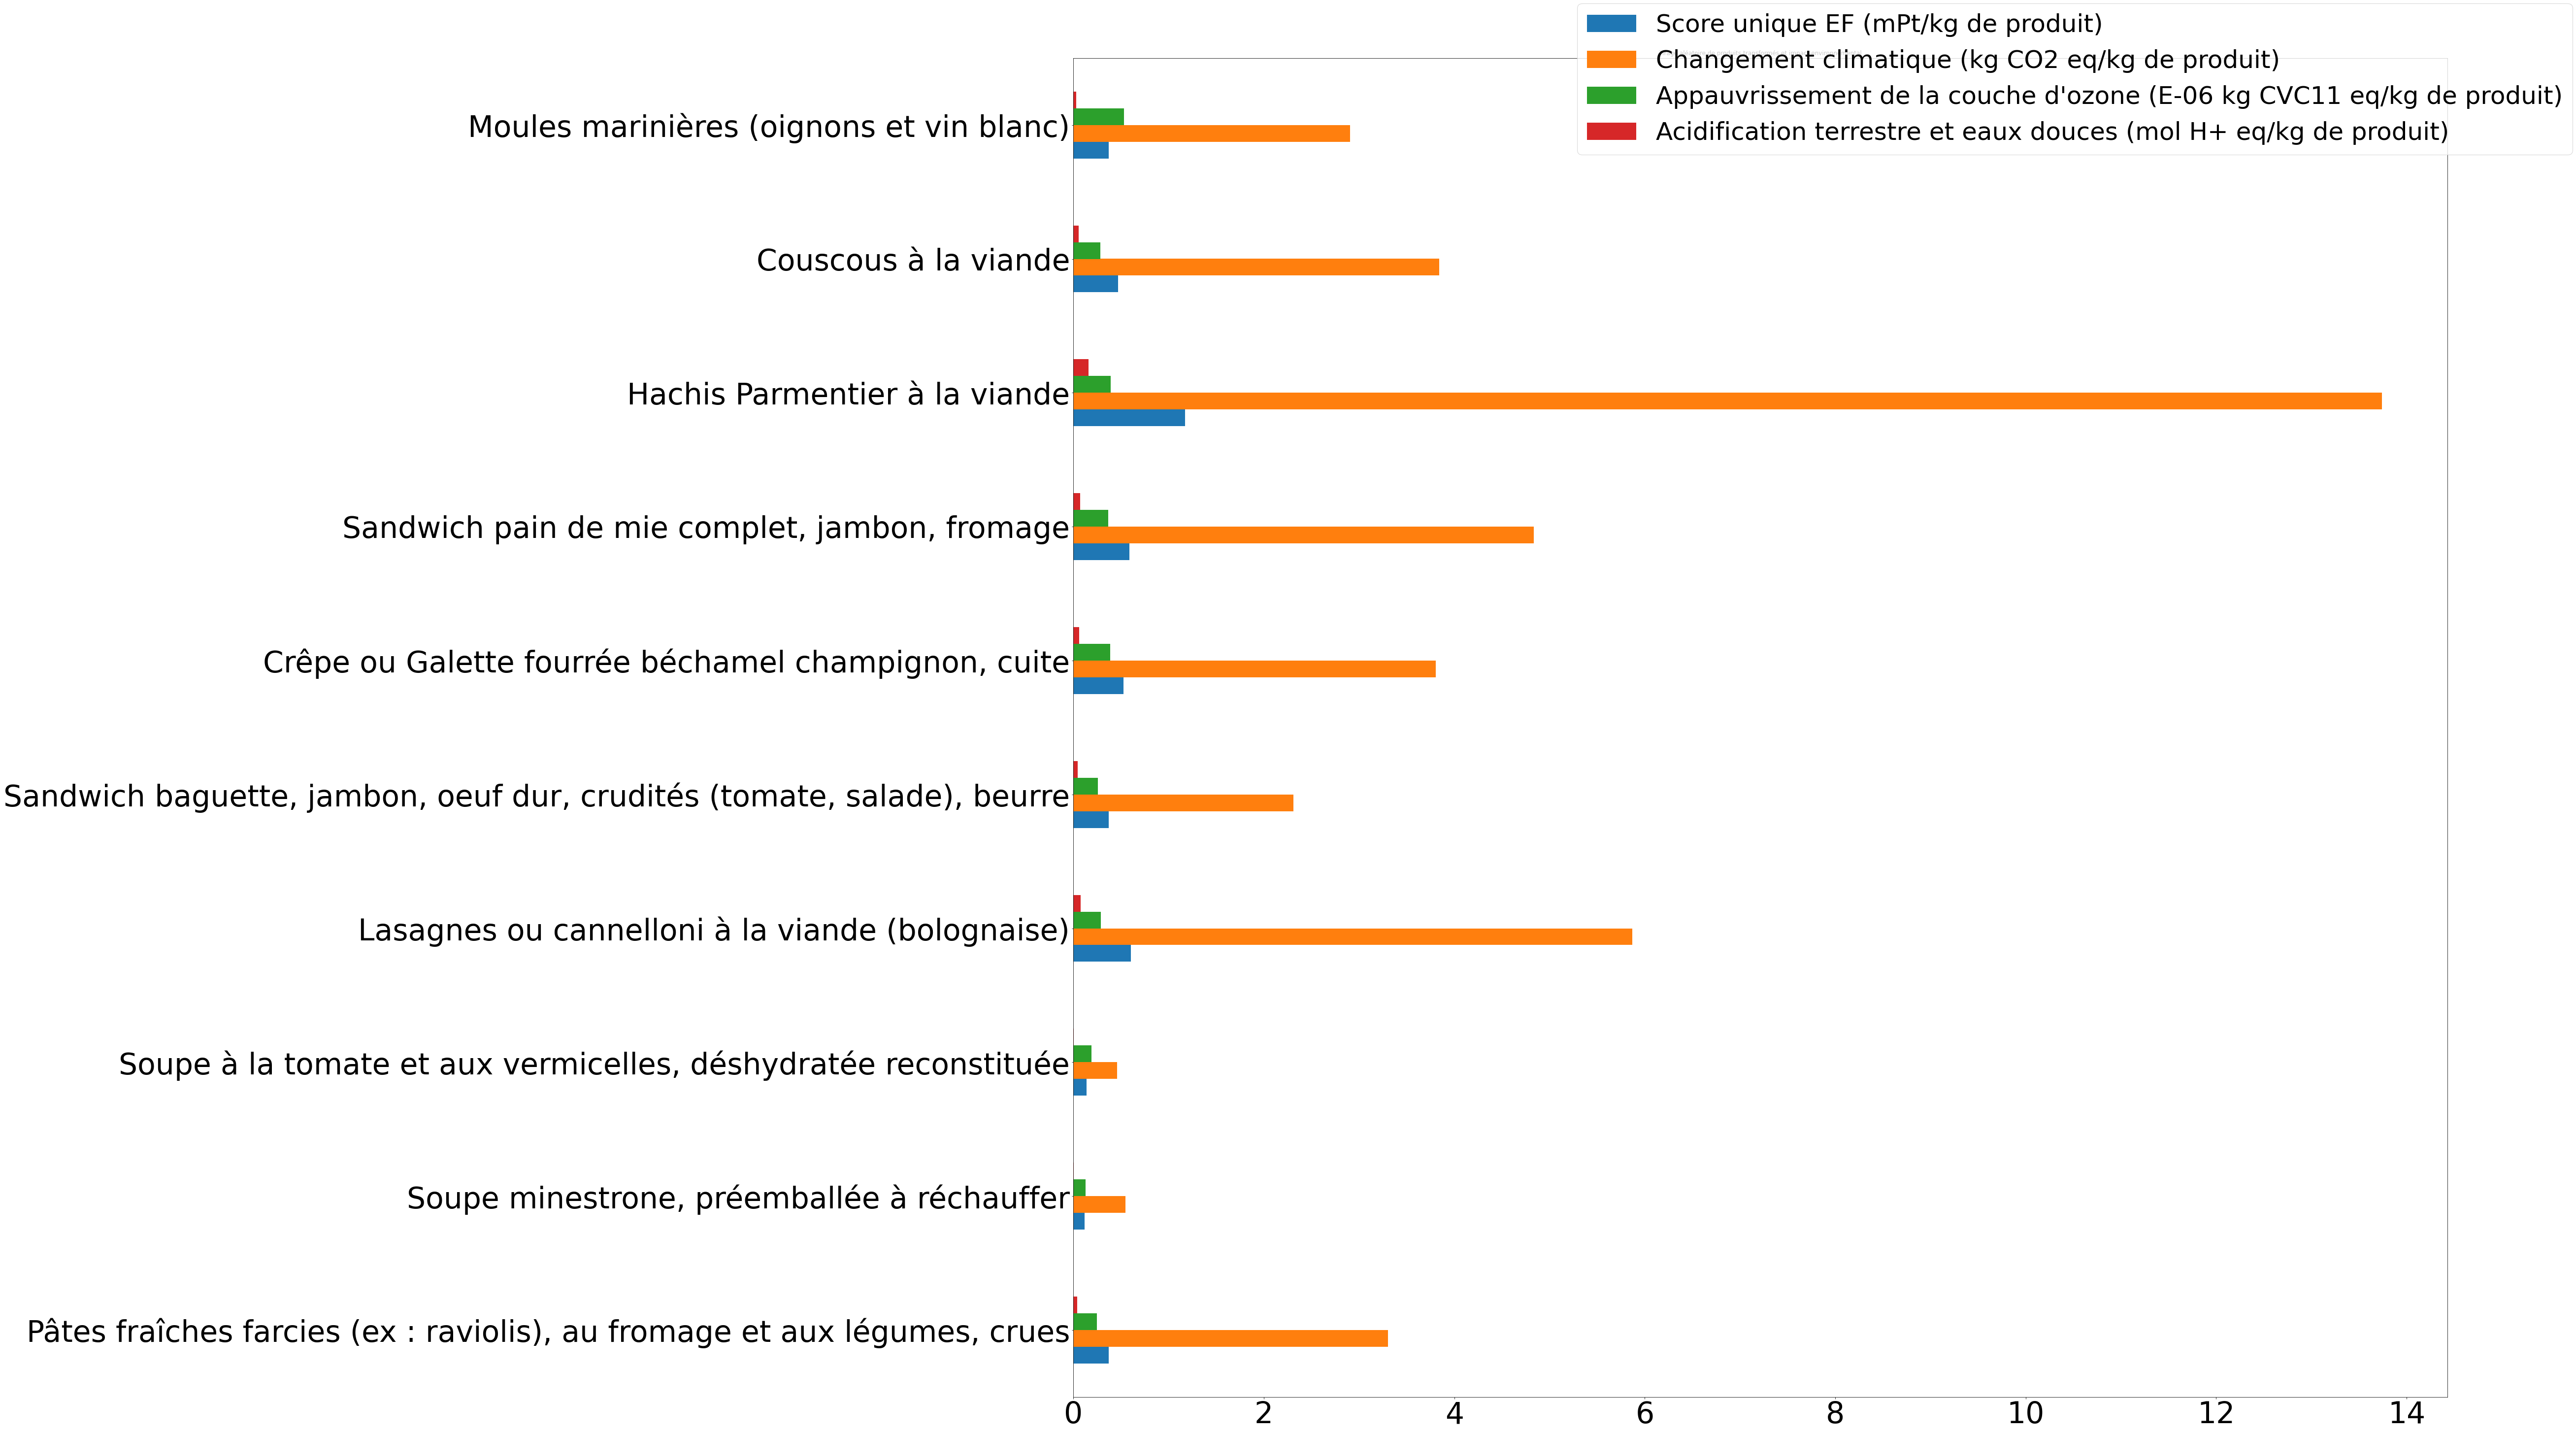

In [31]:
ingredients_cuisines = df_ingredients[df_ingredients["Groupe d'aliment"] =="entrées et plats composés"]

#On va d'abord faire la somme des impacts de chaque ingrédient par plat étudié, pour comparer les plats eux-mêmes.
produits_transformes = ingredients_cuisines.groupby('Nom Français').sum()

#Faisons une rapide comparaison graphique de l'impact de dix d'entre eux (tirés aléatoirement) au sens des différents indicateurs.
produits_transformes.sample(10).plot(kind = "barh", figsize = (50,50), fontsize = 60).legend(bbox_to_anchor=(1.1, 1.05), prop = {'size': 50})
plt.ylabel('')
plt.title('Tirage aléatoire de produits transformés et impact environnemental')

>Lorsque l'on effectue un tirage aléatoire, on tombe sur des plats à impact relativement élevé sur le changement climatique (gratin de poisson), d'autres à impact modéré (sandwich jambon-beurre, chou farci) et d'autres à faible (pizza au fromage) voire à très faible impact (soupe aux légumes verts ou à la tomate). Les exemples entre parenthèses valent pour le premier tirage effectué.

Concetrons-nous plutôt sur les plats à fort impact.

In [32]:
produits_transformes.sort_values("Score unique EF (mPt/kg de produit)",ascending=False).head(20)

,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit)
Nom Français,,,,
Tajine de mouton,3.231135,32.727487,0.737456,0.495555
Navarin d'agneau aux légumes,3.056632,31.033172,0.702619,0.468432
"Salade composée avec viande ou poisson, appertisée, égouttée",2.874360,16.515279,3.743913,0.479506
Moussaka,2.853969,29.248646,0.681920,0.423246
Samossas ou Samoussas,2.449831,28.735466,0.694505,0.341247
Boeuf bourguignon,2.356407,28.207661,0.598819,0.335914
Tripes à la mode de Caen,2.331297,27.501805,0.648103,0.317335
"Tripes à la mode de Caen, préemballées",2.331297,27.501805,0.648103,0.317335
Boeuf aux carottes,2.173262,26.014643,0.568065,0.307075


On va maintenant en choisir un que nous allons décortiquer par ingrédient : Tajine de mouton (celui ayant le plus fort impact). Qu'est ce qui, dans sa composition, a le plus d'effets sur l'environnement ?

In [33]:
df_tajine = ingredients_cuisines[ingredients_cuisines["Nom Français"] =="Tajine de mouton"]
df_tajine.sort_values("Score unique EF (mPt/kg de produit)",ascending=False).reset_index(drop=True)

,Ingredients,Nom Français,Groupe d'aliment,Sous-groupe d'aliment,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit)
0,Viande d'agneau sans os,Tajine de mouton,entrées et plats composés,plats composés,3.097321,31.945739,0.585461,0.488213
1,Autres étapes,Tajine de mouton,entrées et plats composés,plats composés,0.077011,0.577924,0.126744,0.002592
2,Huile combinée (mélange d'huile d'olive et d'h...,Tajine de mouton,entrées et plats composés,plats composés,0.035078,0.110139,0.011034,0.003459
3,Oignons,Tajine de mouton,entrées et plats composés,plats composés,0.006160,0.019761,0.003477,0.000226
4,Tomate,Tajine de mouton,entrées et plats composés,plats composés,0.005529,0.029556,0.004482,0.000243
5,Olives,Tajine de mouton,entrées et plats composés,plats composés,0.004069,0.004872,0.001373,0.000267
6,Courgette,Tajine de mouton,entrées et plats composés,plats composés,0.003680,0.028622,0.004039,0.000230
7,Sucre blanc,Tajine de mouton,entrées et plats composés,plats composés,0.002288,0.010873,0.000846,0.000325
8,Miel,Tajine de mouton,entrées et plats composés,plats composés,0.000000,0.000000,0.000000,0.000000


>On voit clairement que l'immense partie de l'impact environnemental de ce plat est dûe à la viande, les autres ingrédients ayant des impacts relativement négligeables et semblables. 

Repérons plus clairement les sous-groupes d'aliments à plus ou moins fort impact (autres que les plats composés, pour lesquels on sait que la viande ou le poisson expliquent l'essentiel de l'impact).

Text(0, 0.5, '')

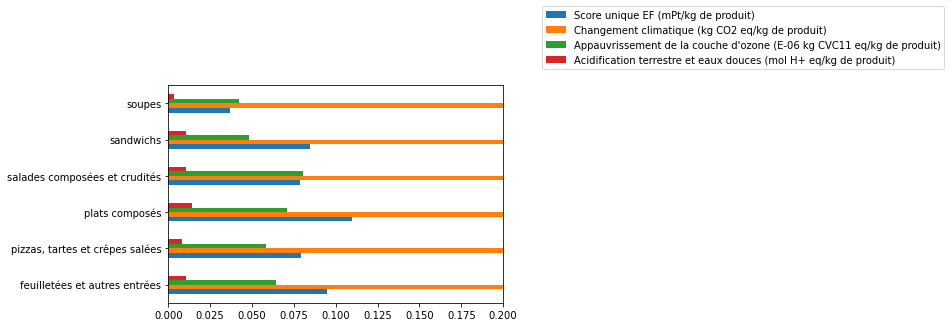

In [34]:
produits_transformes_2 = ingredients_cuisines.groupby("Sous-groupe d'aliment").mean()
produits_transformes_2.plot(kind="barh", xlim=(0,0.2)).legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('')

Le choix ici est de "zoomer" sur les autres indicateurs que le changement climatique. On observe délors que les plats composés disposent d'un scort unique supérieur aux autres groupes d'aliments étudiés. 

### 4) Tableau sur le cycle de vie des aliments

In [14]:
df_etapes.mean()

Score unique EF (mPt / kg de produit)-Moyenne                          0.106036
Score unique EF (mPt / kg de produit) - Agriculture                    0.517223
Score unique EF (mPt / kg de produit) - Transformation                 0.054580
Score unique EF (mPt / kg de produit) - Emballage                      0.021757
Score unique EF (mPt / kg de produit) - Transport                      0.021237
Score unique EF (mPt / kg de produit) - Supermarché et distribution    0.011649
Score unique EF (mPt / kg de produit) - Consommation                   0.009768
DQR                                                                    2.500042
dtype: float64


A première vue, l'agriculture est l'étape qui pollue le plus lors du cycle de vie d'un aliment. Nous pouvons le vérifier graphiquement en considérant les sous-groupes d'aliments:

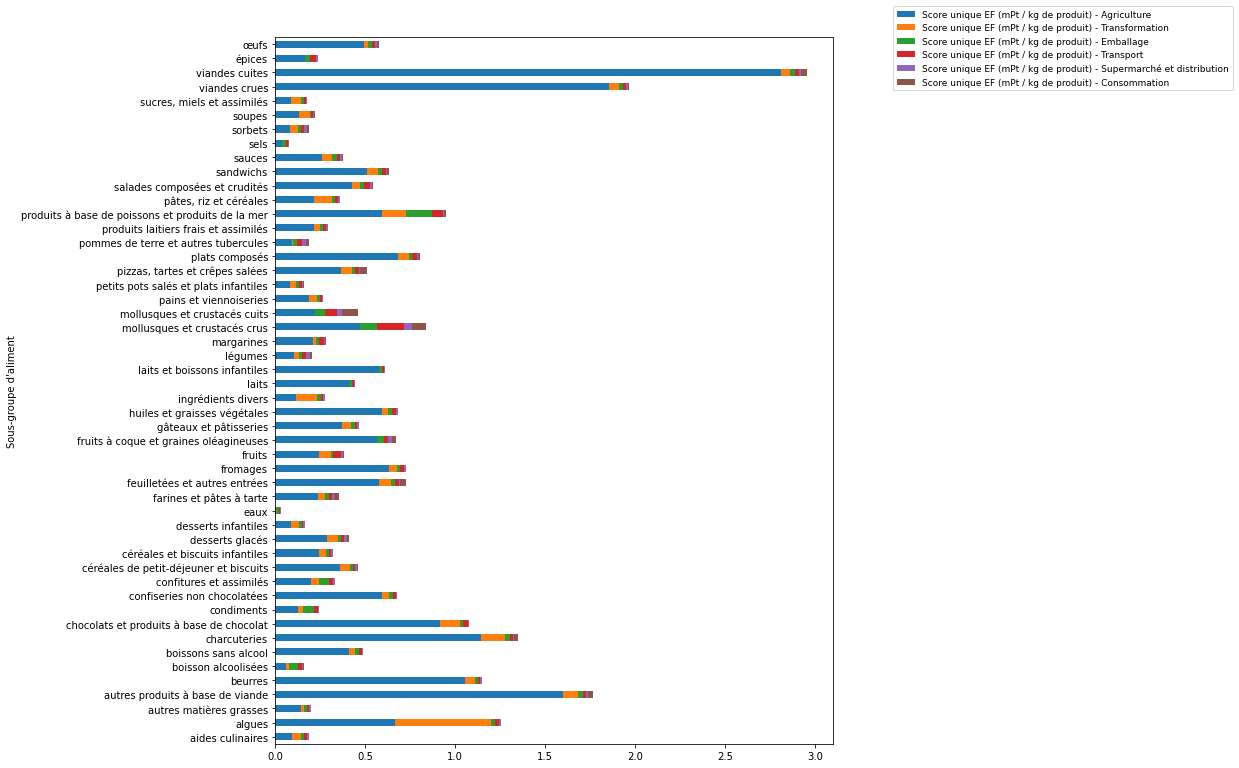

In [36]:
df_etapes_copy = df_etapes.copy()
df_etapes_copy.drop(["DQR", "Score unique EF (mPt / kg de produit)-Moyenne"], axis = "columns", inplace = True)
df_etapes_copy.groupby("Sous-groupe d'aliment").mean().plot(kind="barh",stacked = True, figsize=(10,13)).legend(bbox_to_anchor=(1.1, 1.05),prop = {'size': 9})

In [37]:
df_etapes_fort_impact = df_etapes.sort_values("Score unique EF (mPt / kg de produit)-Moyenne", ascending = False)
df_etapes_fort_impact.head(5)

,Sous-groupe d'aliment,Nom du Produit en Français,Score unique EF (mPt / kg de produit)-Moyenne,Score unique EF (mPt / kg de produit) - Agriculture,Score unique EF (mPt / kg de produit) - Transformation,Score unique EF (mPt / kg de produit) - Emballage,Score unique EF (mPt / kg de produit) - Transport,Score unique EF (mPt / kg de produit) - Supermarché et distribution,Score unique EF (mPt / kg de produit) - Consommation,DQR
902,viandes cuites,"Agneau, collier, braisé ou bouilli",1.016084,5.976579,0.013313,0.027925,0.024134,0.014123,0.040431,2.65
8,autres produits à base de viande,Brochette d'agneau,1.013500,5.976579,0.016769,0.022340,0.019680,0.011298,0.034335,2.80
897,viandes cuites,"Agneau, côte filet, grillée/poêlée",1.012773,5.979301,0.013723,0.027925,0.024302,0.014123,0.017267,2.65
921,viandes cuites,"Agneau, épaule, maigre, rôtie/cuite au four",0.813199,4.781264,0.010650,0.022340,0.019307,0.011298,0.034335,2.65
922,viandes cuites,"Agneau, côtelette, grillée",0.809888,4.783985,0.011060,0.022340,0.019475,0.011298,0.011170,2.65


Les viandes cuites restent le sous-groupe à plus fort impact environnemental d'après le score unique moyen. Il s'agit désormais de mesurer la part de l'agriculture dans son score unique moyen :

Text(0.5, 1.0, 'Part de l agriculture dans le score unique moyen de la viande cuite')

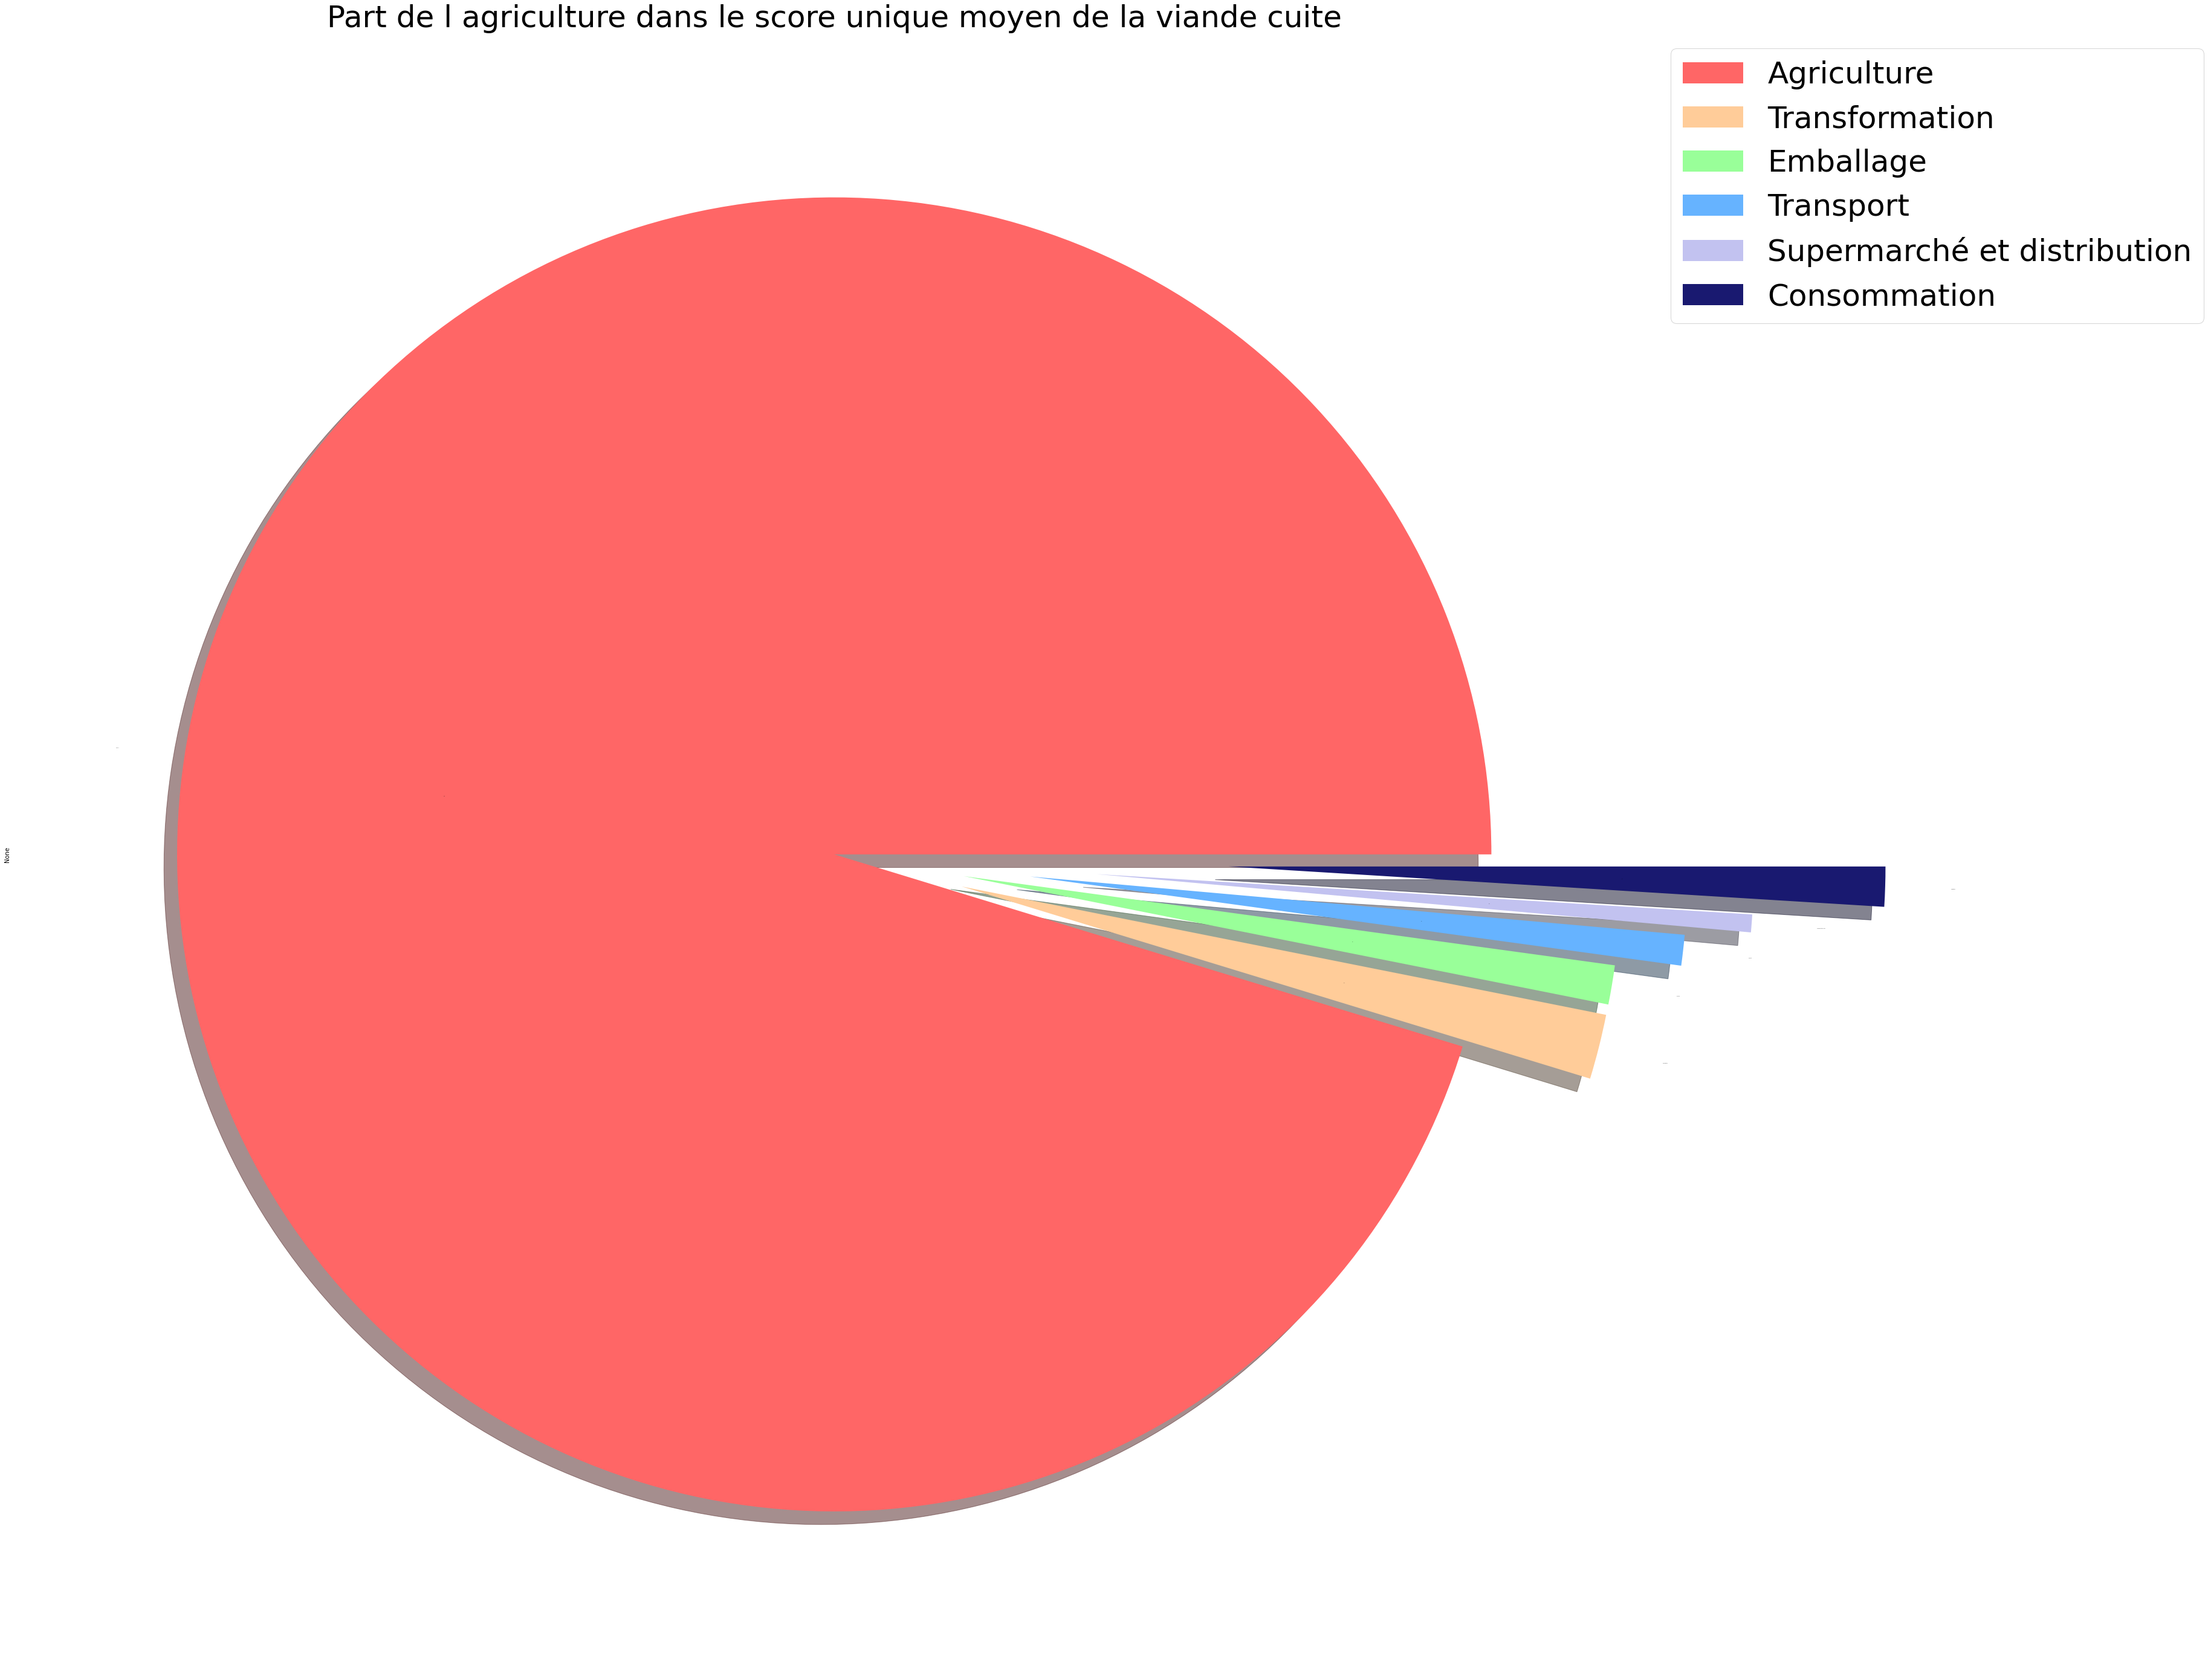

In [38]:
df_etapes_viandescuites = df_etapes_copy[df_etapes_copy["Sous-groupe d'aliment"]=="viandes cuites"]
group_names = ['Agriculture','Transformation','Emballage','Transport','Supermarché et distribution','Consommation']
colors = ['#ff6666','#ffcc99', '#99ff99', '#66b3ff', '#c2c2f0', '#191970' ]
explode = (0, 0.2, 0.2, 0.3, 0.4, 0.6)
df_etapes_viandescuites_graph = df_etapes_viandescuites.mean().plot.pie(subplots=True, autopct='%.2f', fontsize=0.1, figsize = (50,50), colors=colors, labels=group_names, explode =explode, shadow = True)
plt.legend(labels=group_names,bbox_to_anchor=(1, 1),prop = {'size': 50})
plt.title('Part de l agriculture dans le score unique moyen de la viande cuite', size = 50)


>La part du score unique de l'agriculture dans le score unique moyen des viandes cuites est donc de 95%. Le plus grand enjeu environnemental se situe donc à cette étape et peut expliquer "leur sur-impact" sur l'environnement. 

Nous pouvons donc supposer que les principaux impacts naissent dès la culture des produits étudiés et que de là se rajoutent des effets environnementaux négligeables en comparaison lors des étapes de transformation, d'emballage, de transport ou encore de distibution/consommation.

Si nous prenons le tajine de mouton (cas intéressant parce que le mouton est comparable à l'agneau, une viande cuite qui a été indentifiée comme très impactante), à nouveau il est intéressant que l'étape agriculture se démarque :

In [39]:
df_etapes_tajine = df_etapes[df_etapes["Nom du Produit en Français"] == "Tajine de mouton"]
df_etapes_tajine

,Sous-groupe d'aliment,Nom du Produit en Français,Score unique EF (mPt / kg de produit)-Moyenne,Score unique EF (mPt / kg de produit) - Agriculture,Score unique EF (mPt / kg de produit) - Transformation,Score unique EF (mPt / kg de produit) - Emballage,Score unique EF (mPt / kg de produit) - Transport,Score unique EF (mPt / kg de produit) - Supermarché et distribution,Score unique EF (mPt / kg de produit) - Consommation,DQR
629,plats composés,Tajine de mouton,0.539449,3.14623,0.042005,0.016119,0.016917,0.008979,0.006442,2.62



Le score unique de l'étape agriculture tire à nouveau vers le haut le score unique moyen... Comment expliquer que l'Agriculture a autant d'impact aujourd'hui sur le score unique des groupes d'aliment ? Penchons-nous donc désormais sur l'étape Agriculture en particulier.

*Limites de l'étude jusqu'ici :*

- on suppose que l'impact environnemental d'un plat ou d'une recette peut résulter grossièrement de la somme de l'impact de chaque aliment, lui-même déterminé à parti de la somme du coefficient de chaque indicateur. Or rien ne dit que les effets sont linéaires et s'ajoutent tel quel.
- difficile de retracer le chemin de l'aliment (grande diversité d'agneaux par exemple) et donc d'estimer précisément à partir de l'agriculture les déterminantes de l'impact au niveau de la synthèse

### 5) Tableaux agriculture

*Quel est le plus gros pb environnemental causé par l’agriculture ? Regarder par catégorie d’aliment Quel type de pratique agricole impacte le plus l’environnement ? Quelles différences entre bio et non-bio ?*

#### a) Produits non-bio

Maintenant que nous avons une idée des impacts moyens engendrés par l'agriculture de nos aliments, recentrons nos analyses sur les catégories (viandes bovines, porcines, poissons, légumes, etc). 

*Quelles sont celles qui ont un plus fort impact. Engendrent-elles des conséquences sur nos indicateurs dans les memes proportions ?*

Text(0.5, 1.0, 'Impact environnemental de l agriculture non bio par catégorie d aliments')

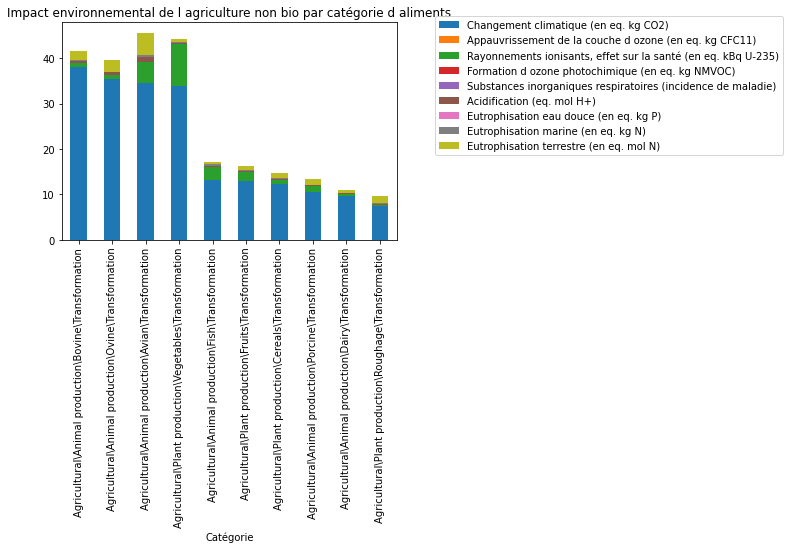

In [40]:
df_agri_nonbio.groupby("Catégorie").sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).head(10).plot(kind="bar", stacked = True).legend(bbox_to_anchor=(1.1,1.05))
plt.title('Impact environnemental de l agriculture non bio par catégorie d aliments')


Nous pouvons tirer deux observations de ce graphique : la première c'est que deux groupes se distinguent particulièrement (la viande bovine, ovie et aviane ainsi que que les légumes en "gros pollueurs", les autres plus bas).La seconde est le large impact en rayonnements ionisants et effets sur la santé provoqué par l'agriculture des légumes.

Concentrons nous désormais sur le changement climatique, sachant que cet indicateur est répertorié comme le plus robustes par Agribalyse.

,Nom du produit,Changement climatique (en eq. kg CO2)
17,Génisse allaitante système d'engraissement co...,20.9806
31,"Agneau système de production conventionnel, à ...",19.5897
16,"Boeuf, moyenne nationale, à la de la ferme / ...",16.9856
32,"Agneau, conventionnel, système Roquefort, à la...",5.28971
34,"Laine, conventionnel, système Roquefort, à la ...",5.22663
...,...,...
200,"Oignon conventionnel, jour court semé, à la fe...",0.0540012
199,"Oignon conventionnel, moyenne nationale, à la ...",0.0539465
198,"Oignon conventionnel, jour long semé, à la fer...",0.0453794
164,"Carotte conventionnelle de saison, avec l'empr...",0.0426529


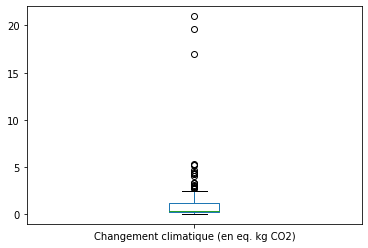

In [41]:
df_agri_nonbio_changement_climatique = df_agri_nonbio[["Nom du produit",'Changement climatique (en eq. kg CO2)']].sort_values('Changement climatique (en eq. kg CO2)', ascending = False)
df_agri_nonbio_changement_climatique
df_agri_nonbio_changement_climatique.plot(kind='box')


La distribution est assez concentrée autour de faibles valeurs, mais quelques valeurs extrêmes beaucoup plus hautes sont repérables (comme pour les donneés sur l'impact des viandes dans le tableau de synthèse)

In [42]:
df_agri_nonbio_cat= df_agri_nonbio[["Catégorie","Changement climatique (en eq. kg CO2)"]].groupby(by = 'Catégorie').sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).copy()
df_agri_nonbio_cat

,Changement climatique (en eq. kg CO2)
Catégorie,
Agricultural\Animal production\Bovine\Transformation,37.966201
Agricultural\Animal production\Ovine\Transformation,35.312712
Agricultural\Animal production\Avian\Transformation,34.620173
Agricultural\Plant production\Vegetables\Transformation,33.896703
Agricultural\Animal production\Fish\Transformation,13.113198
Agricultural\Plant production\Fruits\Transformation,12.977493
Agricultural\Plant production\Cereals\Transformation,12.383102
Agricultural\Animal production\Porcine\Transformation,10.589155
Agricultural\Animal production\Dairy\Transformation,9.630046



Sans surprise, c'est encore la viande qui occupe le haut du podium. Cependant, on observe en quatrieme position les légumes ("Vegetable"), impactant le changement climatique fincipalement du fait de leur transformation agricole.

Inversement, les produits de la pêche européenne figurent en bas du classement.

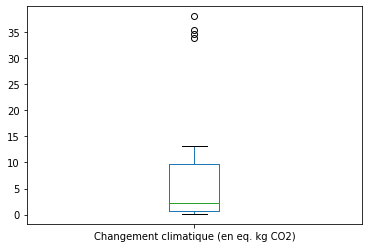

In [43]:
df_agri_nonbio_cat.plot(kind='box')


Ici, les données sont moins ramassé vers le bas. Mais il y a une constante : certains produits se détachent clairement du reste vers le haut du classement. C'est d'ailleurs ce qu'on retrouve dans le graphique ci-après entre les 4 premières catégories d'aliments et le reste.

Text(0.5, 1.0, 'Histogramme de l impact de chaque catégorie sur le changement climatique')

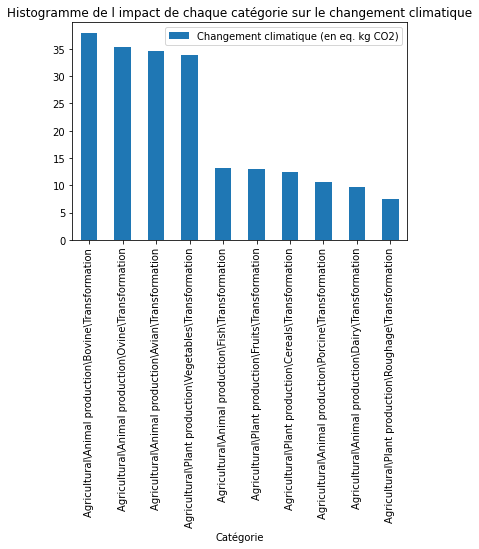

In [44]:
df_agri_nonbio_cat.head(10).plot(kind='bar', stacked = True)
plt.title('Histogramme de l impact de chaque catégorie sur le changement climatique')


#### b) Produits issus de l'agriculture biologique

On procède exactement de la même façon pour les produits biologiques.

Text(0.5, 1.0, 'Impact environnemental pour chaque catégorie d aliments')

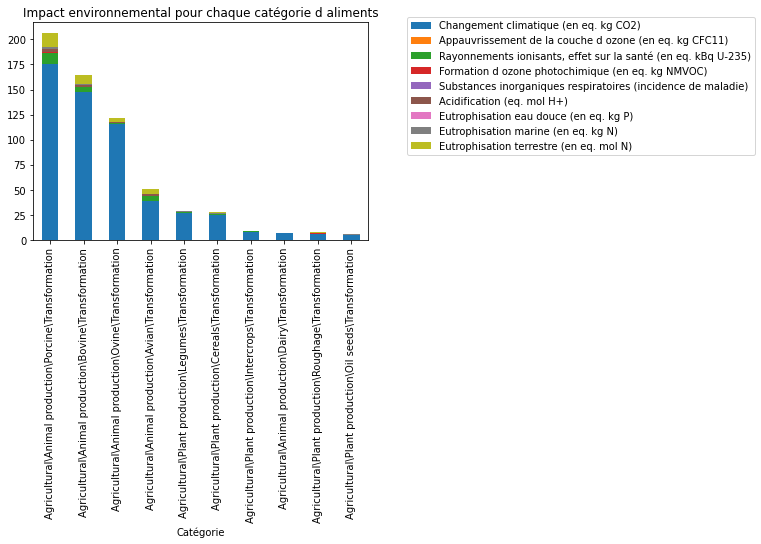

In [45]:
df_agri_bio.groupby("Catégorie").sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).head(10).plot(kind="bar", stacked = True).legend(bbox_to_anchor=(1.1,1.05))
plt.title('Impact environnemental pour chaque catégorie d aliments')

Ici, la viande est toujours en tête, mais cette fois ci, il apparait que les légumes n'ont aucun effet sur les rayonnements ionisants

In [46]:
df_agri_bio_changement_climatique = df_agri_bio[["Nom du produit",'Changement climatique (en eq. kg CO2)']].sort_values('Changement climatique (en eq. kg CO2)', ascending = False).head(10)
df_agri_bio_changement_climatique

,Nom du produit,Changement climatique (en eq. kg CO2)
41,"Réforme truie, biologique, système n ° 3, à la...",59.8712
42,"Réforme truie, biologique, système n ° 4, à la...",39.5717
33,"Lamb, biologique, système n ° 3, à la ferme / ...",25.3612
30,"Réforme brebis, biologique, système n ° 3, à l...",20.6825
29,"Réforme brebis, biologique, système n ° 2, à l...",17.9928
18,"vache Réforme, biologique, système n ° 2, à la...",17.8022
17,"vache Réforme, biologique, système n ° 1, à la...",17.0603
10,"Veau, 13 jours, biologique, plaine système de ...",16.0572
31,"Lamb, biologique, système n ° 1, à la ferme / ...",15.0398
38,"truie Réforme, moyenne biologique, national, à...",13.0708


Encore une fois, c'est la viande qui a le plus grand impact. On distingue pourtant ici des produtis spécifique : la truie, la brebis, la vache, le veau et l'agneau.

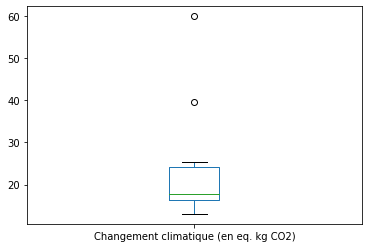

In [47]:

df_agri_bio_changement_climatique.plot(kind='box')

Ce diagramme montre que, cette fois ci, les données sont plus réparties meme ci un produit se détachent négativement sur reste : la truie.

Comme précedemment, regroupons les catégorie pour adopter une vue d'ensemble

In [48]:
df_agri_bio_cat= df_agri_bio[["Catégorie","Changement climatique (en eq. kg CO2)"]].groupby(by = 'Catégorie').sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).copy()
df_agri_bio_cat

,Changement climatique (en eq. kg CO2)
Catégorie,
Agricultural\Animal production\Porcine\Transformation,175.015114
Agricultural\Animal production\Bovine\Transformation,147.492058
Agricultural\Animal production\Ovine\Transformation,115.679525
Agricultural\Animal production\Avian\Transformation,38.542715
Agricultural\Plant production\Legumes\Transformation,26.788471
Agricultural\Plant production\Cereals\Transformation,24.765599
Agricultural\Plant production\Intercrops\Transformation,8.398198
Agricultural\Animal production\Dairy\Transformation,6.451675
Agricultural\Plant production\Roughage\Transformation,6.123840



Sans surprise, la viande porcine prend la tête du classement, et les fruits et légumes ferment la marche. Encore une fois, le trio animal de tete est largement pire en terme de changement climatique que ses camarades, chose que nous retrouvons dans les graphiques ci après.

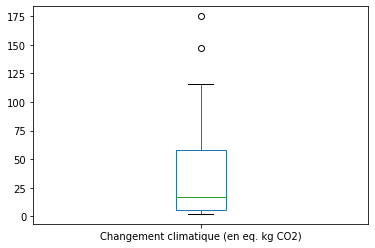

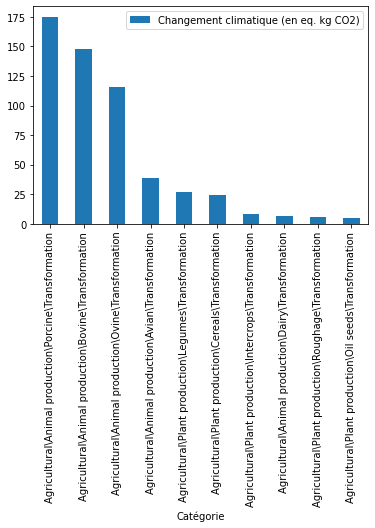

In [49]:
df_agri_bio_cat.plot(kind='box')
df_agri_bio_cat.head(10).plot(kind='bar', stacked = True)


#### c) Comparaison bio/ non bio

,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
0,1.049320,9.521967e-08,0.108562,0.005163,1.636942e-07,0.019641,0.000317,0.008636,0.079397
1,2.584709,8.166867e-08,0.127420,0.004708,2.514717e-07,0.038240,0.000402,0.020040,0.169300


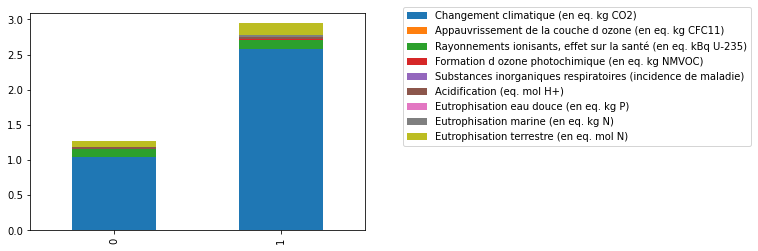

In [50]:
df_new_line_bio = pd.DataFrame([df_agri_bio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_new_line_nonbio = pd.DataFrame([df_agri_nonbio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_comparaison = pd.concat([df_new_line_nonbio,df_new_line_bio],ignore_index= True)
df_comparaison
df_comparaison.plot(kind='bar', stacked = True).legend(bbox_to_anchor=(1.1,1.05))


On observe un résultat étrange: les produits bio ont en moyenne un impact supérieur ! Hypothèse : comme les produits étudiés ne sont pas les mêmes dans les deux tableaux, il y a sans doute un biais de sélection (pour les produits bios, il s'agit sans doute de produits qui ont globalement un impact supérieur qu'ils soient bios ou non, aux produits non-bio étudiés), qui explique ce résultat contre-intuitif, mais qui interdit d'y voir un effet causal (qui signifierait que ce serait parce qu'ils sont bio que les produits polluent, ce qui est absurde).

Retour sur un plat cuisiné : le tajine de mouton

Regardons plus en détail l'empreinte agricole du tajine de mouton. D'après le tableau des ingrédients ci-dessus, le Tajine est composé de viande d'agneau, d'huile d'olive, d'oignons, de tomates, d'olives, de courgettes, de sucre blanc et de miel.

Nous allons comparer tajine non biologique et tajine biologique.

In [51]:
df_agri_tajine_nonbio = pd.concat([df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Agneau, conventionnel, système Roquefort, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Oignon conventionnel, moyenne nationale, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Tomate conventionnelle, panier moyen, serre chauffée, moyenne nationale, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Courgette conventionnelle, moyenne nationale, à la ferme / FR U"]])
df_agri_tajine_nonbio

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
32,"Agneau, conventionnel, système Roquefort, à la...",Agricultural\Animal production\Ovine\Transform...,5.28971,1.15332e-07,0.249992,0.00590815,7.1411e-07,0.104666,0.000245465,0.0215262,0.464752
199,"Oignon conventionnel, moyenne nationale, à la ...",Agricultural\Plant production\Vegetables\Trans...,0.0539465,1.16202e-08,0.038109,0.000337185,3.9524e-09,0.000678278,3.5755e-05,0.00154375,0.00229033
212,"Tomate conventionnelle, panier moyen, serre ch...",Agricultural\Plant production\Vegetables\Trans...,2.36228,3.98625e-07,0.202376,0.00329812,5.61111e-08,0.00569136,0.000566563,0.00278114,0.0130372
202,"Courgette conventionnelle, moyenne nationale, ...",Agricultural\Plant production\Vegetables\Trans...,0.146887,1.69283e-08,0.0276366,0.000855528,8.33909e-09,0.00149362,4.11995e-05,0.00121632,0.00680692


In [52]:
df_agri_tajine_bio = pd.concat([df_agri_bio[df_agri_bio["Nom du produit"]=="Lamb, biologique, système n ° 1, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Oignon conventionnel, moyenne nationale, à la ferme / FR U"],df_agri_bio[df_agri_bio["Nom du produit"]=="Tomate, biologique, la production à effet de serre, la moyenne nationale, à effet de serre / FR U"],df_agri_bio[df_agri_bio["Nom du produit"]=="Courge, printemps, sous tunnel, porte biologique, à la ferme / FR U"]])
df_agri_tajine_bio

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
31,"Lamb, biologique, système n ° 1, à la ferme / ...",Agricultural\Animal production\Ovine\Transform...,15.0398,2.3292e-07,0.11931,0.0176732,7.48907e-07,0.115401,0.000622138,0.0763973,0.516235
199,"Oignon conventionnel, moyenne nationale, à la ...",Agricultural\Plant production\Vegetables\Trans...,0.0539465,1.16202e-08,0.038109,0.000337185,3.9524e-09,0.000678278,3.5755e-05,0.00154375,0.00229033
219,"Tomate, biologique, la production à effet de s...",Agricultural\Plant production\Vegetables\Trans...,0.205365,2.39061e-08,0.0455336,0.000673468,1.04074e-08,0.00174245,4.16843e-05,0.000338623,0.00879566
218,"Courge, printemps, sous tunnel, porte biologiq...",Agricultural\Plant production\Vegetables\Trans...,0.161423,1.6041e-08,0.0419865,0.000773917,9.47409e-09,0.00171381,3.80417e-05,0.00051385,0.00914471



remarque : pour le tajine bio, nous avons bien sélectionné les mêmes aliments en version bio, hormis les oignons que nous avons repris dans le tableau non bio à défaut de les avoir trouvé dans le tableau bio

,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
0,1.963206,1.356262e-07,0.129528,0.002600,1.956281e-07,0.028132,0.000222,0.006767,0.121722
1,3.865129,7.112185e-08,0.061235,0.004864,1.931851e-07,0.029884,0.000184,0.019698,0.134116


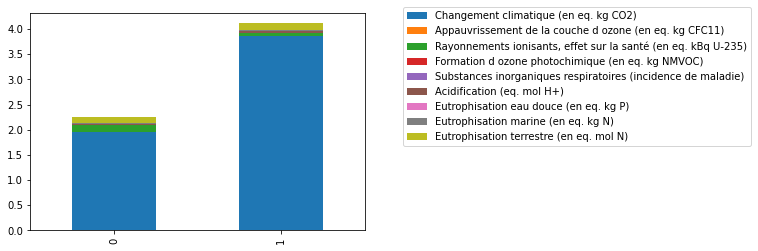

In [53]:
df_n_line_bio = pd.DataFrame([df_agri_tajine_bio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_n_line_nonbio = pd.DataFrame([df_agri_tajine_nonbio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_compa_tajine= pd.concat([df_n_line_nonbio,df_n_line_bio],ignore_index= True)
df_compa_tajine
df_compa_tajine.plot(kind='bar', stacked = True).legend(bbox_to_anchor=(1.1,1.05))


Encore une fois, les résultats sont étonnants : l'impacte sur le changement climatique du tajine bio est largement supérieur à celui du tajine non bio, la différence se faisant sur l'agneau (impact_nonbio = 5 < impact_bio = 15)

Heureusement, les nouvelles ne sont pas que négatives: les effets sur le rayonnemant ionistants et la santé sont tout de même largement inférieur pour le tajine bio que pour celui non bio.

III.Début partie modélisation


L'objectif de cette dernière partie est de prédire l'impact des indicateurs environnementaux sur le score unique des aliments (que l'on utilise pour estimer leur impact global) afin d'ensuite d'appliquer cette méthode à des recettes originales et non présent dans le dataset, à partir des coefficients estimés par les modèles.

1) Régression linéaire multiple

Dans un premier temps, tentons de réaliser une régression linéaire multiple afin de tenter de prédire l'effet des indicateurs d'impact environnemental sur le score unique : peut-on retrouver avec fiabilité le score unique avec les indicateurs les plus robustes ?

Pour cela, nous choisissons arbitrairement de prendre 80% des données comme observations pour réaliser la régression linéaire et 20% des données est pris en tant que test afin de vérifier la fiabilité des coefficiens obtenus.

In [15]:
import seaborn as sns

In [64]:
X=pd.DataFrame(np.c_[df_synthese_bref['Changement climatique (kg CO2 eq/kg de produit)'],df_synthese_bref["Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)"], df_synthese_bref["Acidification terrestre et eaux douces (mol H+ eq/kg de produit)"]])
Y=df_synthese_bref['Score unique EF (mPt/kg de produit)']

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [83]:

for test_size in np.linspace(0.2, 0.3, 0.1): #j'ai essayé aussi avec np.arange, mais ça ne marche pas non plus !
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size, random_state=5)
 
    lmodellineaire = LinearRegression()
    lmodellineaire.fit(X_train, Y_train)

    y_train_predict = lmodellineaire.predict(X_train)

    rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
    r2 = r2_score(Y_train, y_train_predict)
    print('La performance du modèle sur la base dapprentissage')
    print('--------------------------------------')
    print('Lerreur quadratique moyenne est {}'.format(rmse))
    print('le score R2 est {}'.format(r2))
    print('\n')
 
    y_test_predict = lmodellineaire.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
    r2 = r2_score(Y_test, y_test_predict)
    print('La performance du modèle sur la base de test')
    print('--------------------------------------')
    print('Lerreur quadratique moyenne est {}'.format(rmse))
    print('le score R2 est {}'.format(r2))

    print('--------------------------------------')
    a = lmodellineaire.coef_
    print(a)

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

y_train_predict = lmodellineaire.predict(X_train)

rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

print('--------------------------------------')
a = lmodellineaire.coef_
print(a)

LinearRegression()

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.10418634948180162
le score R2 est 0.9862443659717877


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 6.097221975623865
le score R2 est -39.15036359694407
--------------------------------------
[0.04051828 0.30303773 3.15028513]


Cette fois c'est beaucoup plus logique : en régressant le score unique sur les quelques indicateurs les plus robustes, comme ces derniers sont combinaison linéaire du score unique, on obtient une forte variance et un R carré très mauvais sur la base de test : notre problème a un problème d'overfitting 

On réessaye avec un critère 70/30 pour splitter les données.

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=5)
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

y_train_predict = lmodellineaire.predict(X_train)

rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

print('--------------------------------------')
a = lmodellineaire.coef_
print(a)

LinearRegression()

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.10621164091572019
le score R2 est 0.9844933469932158


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 5.1937608828799675
le score R2 est -25.433968754583248
--------------------------------------
[0.04080085 0.3161354  3.11811074]


En choisissant ce critère, on diminue très légèrement l'overfitting mais le modèle reste inadapté !

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=31)
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

y_train_predict = lmodellineaire.predict(X_train)

rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

print('--------------------------------------')
a = lmodellineaire.coef_
print(a)

LinearRegression()

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.2171975459001981
le score R2 est 0.9395534594164088


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 0.11085721235850486
le score R2 est 0.9863956431975671
--------------------------------------
[3.56980902e-02 7.44277817e-04 4.03477149e+00]


On remarque qu'en changeant le random_state utilisé pour décider quelle donnée va dans l'échantillon test ou train, les coefficients estimés ainsi que notre R^2 change drastiquement : il peut aller de négatif à proche de 1. 0n peut donc alors observer une variance élevée de l'estimation, les coefficients estimés sont très erratiques et dépendants de l'échantillon d'apprentissage. Nous pouvons alors suspecter un problème de sur-apprentissage/overfitting. Le modèle de régression linéaire multiple est donc ici instable et sa performance prédictive faible.

Pour y prévenir, nous sommes obligés d'accepter une légère augmentaion du biais pour obtenir une réduction de la variance. Pour cela, nous pouvons réguler la modélisation en imposant des contraintes sur les paramètres estimés de la régression. Nous pouvon tester plusieurs possibilités comme la validation croisée ou différentes méthodes de régularisation comme Lasso.


2) LASSO

LASSO permet de sélectionner les variables explicatives, qui peut aider à minimiser l'erreur de prédiction.

On va commencer par l'étape de preprocessing, permettant de standardiser les données.

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X =scaler.fit_transform(X)
Y = scaler.fit_transform(Y.values.reshape(-1, 1))
X.mean()

3.909451090839616e-17

In [85]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [111]:
def lasso(X_train,X_test,y_train,y_test) :
    
    lasso = Lasso()
    lasso.fit(X_train,y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    coeff_used = np.sum(lasso.coef_!=0)

    print("training score:", train_score)
    print("test score: ", test_score)
    print("number of features used: ", coeff_used)
    print("les coefficents sont :", lasso.coef_)

In [113]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=5)
lasso(X_train,X_test,y_train,y_test)

training score: 0.9238268310327116
test score:  0.8608877250210445
number of features used:  1
les coefficents sont : [0.07521527 0.         0.        ]


In [114]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)
lasso(X_train,X_test,y_train,y_test)

training score: 0.8832231614019712
test score:  0.936157816760608
number of features used:  1
les coefficents sont : [0.07540153 0.         0.        ]


In [115]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=200)
lasso(X_train,X_test,y_train,y_test)

training score: 0.9295016307353541
test score:  0.8474240754416701
number of features used:  1
les coefficents sont : [0.07614498 0.         0.        ]



A l'inverse de la régression linéaire qui présentait une grande variance dans les coefficients estimés et dans le R^2 en fonction du random_state ou de la séparation entre test et apprentissage choisis, Lasso présente davantage de stabilité. L'estimation est d'ailleurs bien meilleur puisque le R^2 de la base apprentissage et de la base test sont relativement proches de 1.

La valeur par défaut du coefficient de pénalité est alpha = 1. Cependant, nous pouvons remarquer que la valeur prise par défaut du coefficient de pénalité (alpha = 1) est très inadaptée à notre modèle : les R^2 sont tous les deux presque nuls et les coefficients sont tous mis à zéro, ce qui n'est pas ce que nous recherchons. Peut-on encore augmenter les R^2 en changeant notre coefficient de pénalité alpha ?

Lorsque α est trop élevé, tous les coefficients de la régression sont nuls, nous en avons une
illustration ici ; lorsque α est trop faible, proche de 0, nous obtenons les coefficients de la
régression linéaire multiple usuelle. Il faut trouver le juste milieu et c’est toute la difficulté de
la régression Lasso

On utilise le lasso path pour identifier des alphas plus performants en prennant des valeurs d'alpha à tester.
D'abord manuellement.

In [98]:
def manual_lasso_path(alpha):
    
    lasso = Lasso(alpha, max_iter=10e5)
    lasso.fit(X_train,Y_train)
    train_score=lasso.score(X_train,Y_train)
    test_score=lasso.score(X_test,Y_test)
    coeff_used = np.sum(lasso01.coef_!=0)

    print("training score for alpha:", train_score) 
    print("test score for alpha: ", test_score)
    print("number of features used: for alpha:", coeff_used)
    print("les coefficents sont :", lasso.coef_)
 

In [100]:
manual_lasso_path(0.1)

training score for alpha: 0.9420152799307252
test score for alpha:  0.8586302820939838
number of features used: for alpha: 1
les coefficents sont : [0.08512265 0.         0.        ]


In [103]:
manual_lasso_path(0.01)

training score for alpha: 0.942140824085516
test score for alpha:  0.858722751696295
number of features used: for alpha: 1
les coefficents sont : [8.60203673e-02 1.48558435e-05 0.00000000e+00]


In [102]:
manual_lasso_path(0.001)

training score for alpha: 0.9766775872944913
test score for alpha:  0.905796301554568
number of features used: for alpha: 1
les coefficents sont : [4.51044698e-02 4.33366464e-04 3.22876906e+00]


Le R^2 ne varie que très peu ; ainsi un alpha entre inférieur ou égal à 0,1 semble adapté. Le modèle semble alors avoir un très bon pouvoir prédictif (R^2 proche de un), et une telle valeur d'alpha a pour avantage de conserver deux voire trois coefficients non nuls/ variables explicatives.

Une méthode répandue est la validation croisée k-fold, consistant à partitionner les données en K morceaux et à considèrer chaque pli successivement comme un échantillon de test en apprenant sur les K-1 échantillons restants. Les K indicateurs ainsi calculés sur les K échantillons de test peuvent être moyennés et comparés pour plusieurs valeurs des hyperparamètres.

Commençons avec k = 5

Lasso()

Lasso()

1.0 [0. 0. 0.]


Lasso(alpha=0.9)

Lasso(alpha=0.9)

0.9 [0.         0.         0.05952783]


Lasso(alpha=0.8)

Lasso(alpha=0.8)

0.8 [0.         0.         0.15973309]


Lasso(alpha=0.7)

Lasso(alpha=0.7)

0.7 [0.05130436 0.         0.21168165]


Lasso(alpha=0.6)

Lasso(alpha=0.6)

0.6 [0.10571495 0.         0.26070851]


Lasso(alpha=0.5)

Lasso(alpha=0.5)

0.5 [0.16012555 0.         0.30973536]


Lasso(alpha=0.4)

Lasso(alpha=0.4)

0.4 [0.21453614 0.         0.35876222]


Lasso(alpha=0.3)

Lasso(alpha=0.3)

0.3 [0.26894673 0.         0.40778907]


Lasso(alpha=0.2)

Lasso(alpha=0.2)

0.2 [0.32335732 0.         0.45681593]


Lasso(alpha=0.1)

Lasso(alpha=0.1)

0.1 [0.37776791 0.         0.50584278]


Lasso(alpha=0.001)

Lasso(alpha=0.001)

0.001 [0.43125314 0.00422429 0.55476526]


Lasso(alpha=0.0001)

Lasso(alpha=0.0001)

0.0001 [0.43168561 0.00485524 0.55526441]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

CV [0.38328512 0.00213279 0.60100451]


Text(0.5, 0, '$\\alpha$')

Text(0, 0.5, 'Score')

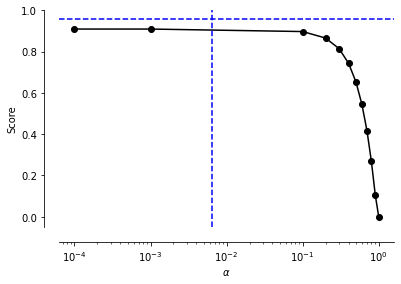

In [28]:
#Faire un lasso cv > une validation croisée

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LassoCV
alphas = np.array([1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.001,0.0001])
scores = np.empty_like(alphas)
lcv = LassoCV(alphas=alphas,normalize=False,fit_intercept=False,random_state=0,cv=5)

for i,a in enumerate(alphas):
    lasso = linear_model.Lasso()
    lasso.set_params(alpha=a)
    lasso.fit(X_train, Y_train)
    scores[i] = lasso.score(X_test, Y_test)
    print(a, lasso.coef_)

lassocv = linear_model.LassoCV()
lassocv.fit(X, Y)
lassocv_score = lassocv.score(X, Y)
lassocv_alpha = lassocv.alpha_
print('CV', lassocv.coef_)

plt.plot(alphas, scores, '-ko')
plt.axhline(lassocv_score, color='b', ls='--')
plt.axvline(lassocv_alpha, color='b', ls='--')
plt.xlabel(r'$\alpha$')
plt.ylabel('Score')
plt.xscale('log')
sns.despine(offset=15)

Lorsqu'alpha évolue de 0,001 à 1, le score associé à la performance du modèle sur la base de test reste globalement très élevée, même si elle est maximale au début, puis décroît légèrement au-delà de 0,1.

Puis avec k = 20.

Lasso()

Lasso()

1.0 [0. 0. 0.]


Lasso(alpha=0.9)

Lasso(alpha=0.9)

0.9 [0.         0.         0.05952783]


Lasso(alpha=0.8)

Lasso(alpha=0.8)

0.8 [0.         0.         0.15973309]


Lasso(alpha=0.7)

Lasso(alpha=0.7)

0.7 [0.05130436 0.         0.21168165]


Lasso(alpha=0.6)

Lasso(alpha=0.6)

0.6 [0.10571495 0.         0.26070851]


Lasso(alpha=0.5)

Lasso(alpha=0.5)

0.5 [0.16012555 0.         0.30973536]


Lasso(alpha=0.4)

Lasso(alpha=0.4)

0.4 [0.21453614 0.         0.35876222]


Lasso(alpha=0.3)

Lasso(alpha=0.3)

0.3 [0.26894673 0.         0.40778907]


Lasso(alpha=0.2)

Lasso(alpha=0.2)

0.2 [0.32335732 0.         0.45681593]


Lasso(alpha=0.1)

Lasso(alpha=0.1)

0.1 [0.37776791 0.         0.50584278]


Lasso(alpha=0.001)

Lasso(alpha=0.001)

0.001 [0.43125314 0.00422429 0.55476526]


Lasso(alpha=0.0001)

Lasso(alpha=0.0001)

0.0001 [0.43168561 0.00485524 0.55526441]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

CV [0.38328512 0.00213279 0.60100451]


Text(0.5, 0, '$\\alpha$')

Text(0, 0.5, 'Score')

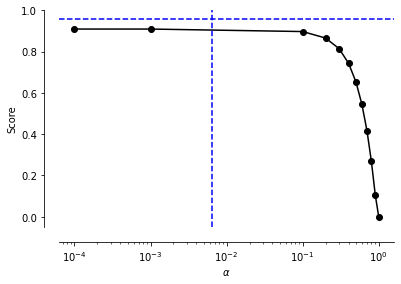

In [29]:
lcv = LassoCV(alphas=alphas,normalize=False,fit_intercept=False,random_state=0,cv=20)
for i,a in enumerate(alphas):
    lasso = linear_model.Lasso()
    lasso.set_params(alpha=a)
    lasso.fit(X_train, Y_train)
    scores[i] = lasso.score(X_test, Y_test)
    print(a, lasso.coef_)

lassocv = linear_model.LassoCV()
lassocv.fit(X, Y)
lassocv_score = lassocv.score(X, Y)
lassocv_alpha = lassocv.alpha_
print('CV', lassocv.coef_)

plt.plot(alphas, scores, '-ko')
plt.axhline(lassocv_score, color='b', ls='--')
plt.axvline(lassocv_alpha, color='b', ls='--')
plt.xlabel(r'$\alpha$')
plt.ylabel('Score')
plt.xscale('log')
sns.despine(offset=15)

On obtient une courbe similaire.

D'après ces graphiques, l'alpha optimisant le score vaut environ 0.01. Le score vaut alors 0.91 et on garde bien deux coefficients non nuls (on est à la limite du ridge car on a gardé deux variables et non plus une seule comme en prenant alpha à 0.1). Comme un alpha très petit est adapté à nos données, Ridge est susceptible d'être encore plus performant.

3) Ridge  

L'intérêt de Ridge est d'imposer une pénalité alpha sur les coefficients qui va réduire leur taille sans les rendre nuls, de manière à rendre le modèle robuste à la multicolinéarité entre les variables. Plus alpha est grand (cette fois-ci), plus on accroît cette robustesse.

Ridge()

Ridge(alpha=0.9)

Ridge(alpha=0.8)

Ridge(alpha=0.7)

Ridge(alpha=0.6)

Ridge(alpha=0.5)

Ridge(alpha=0.4)

Ridge(alpha=0.3)

Ridge(alpha=0.2)

Ridge(alpha=0.1)

Text(0.5, 0, 'Alpha (Regularization Parameter)')

Text(0, 0.5, 'Beta (Predictor Coefficients)')

Text(0.5, 1.0, 'Ridge Coefficients vs Regularization Parameters')

(0.055, 1.045, -0.16924193641645208, 3.5606614121170335)

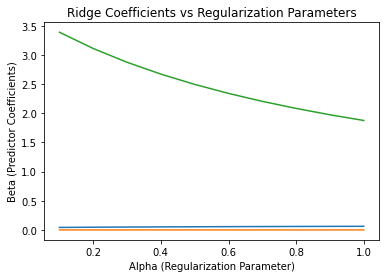

In [104]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
coef=[]
alphas = np.array([1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

for a in alphas:
  ridgereg=Ridge(alpha=a)
  ridgereg.fit(X_train,Y_train)
  coef.append(ridgereg.coef_)

###Make plot of Beta as a function of Alpha
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(alphas,coef)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')
ax.axis('tight')
###ax.legend(loc='best')
fig.savefig('coef_vs_alpha.png')

Pas besoin de chercher précisément un alpha optimal, testons simplement plusieurs valeurs manuellement pour voir si on augmente ou non le pouvoir prédictif du modèle.  

In [105]:
X_train, X_test , Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [106]:
def ridge_coeff_search(alpha):
    
    ridge= Ridge(alpha)
    ridge.fit(X_train, Y_train)             
    pred = ridge.predict(X_test)
    Ridge_train_score = ridge.score(X_train,Y_train)
    Ridge_test_score = ridge.score(X_test, Y_test)

    print("training score for alpha:", train_score) 
    print("test score for alpha: ", test_score)
    print("number of features used: for alpha:", coeff_used)
    print("les coefficents sont :", lasso.coef_)

In [107]:
ridge_coeff_search(0.1)

training score for alpha: 0.9295016307353541
test score for alpha:  0.8474240754416701
number of features used: for alpha: 1
les coefficents sont : [0.07614498 0.         0.        ]


Mauvais, ce qui est logique : alpha est trop petit.

In [108]:
ridge_coeff_search(100)

training score for alpha: 0.9295016307353541
test score for alpha:  0.8474240754416701
number of features used: for alpha: 1
les coefficents sont : [0.07614498 0.         0.        ]


Pour alpha = 100, on obtient un excellent test score, encore meilleur qu'en optimisant le lasso.

In [109]:
ridge_coeff_search(1000)

training score for alpha: 0.9295016307353541
test score for alpha:  0.8474240754416701
number of features used: for alpha: 1
les coefficents sont : [0.07614498 0.         0.        ]


C'est beaucoup moins bien : lorsqu'alpha devient trop grand, même le training score diminue. Ainsi, alpha = 100 semble être autour de la valeur optimale.

Nous pouvons cibler cette valeur à l'aide d'une cross validation :

In [34]:
regr_cv=RidgeCV(alphas=range(1,100))
model_cv=regr_cv.fit(X,Y)
print("alpha", model_cv.alpha_)
print("training score:", model_cv.score(X_train,Y_train))
print("test score:", model_cv.score(X_test,Y_test))
print("les coefficents sont :", model_cv.coef_)

alpha 80
training score: 0.9455295981924996
test score: 0.9716414184751633
les coefficents sont : [[0.43161661 0.00761904 0.50607254]]


Notre meilleur modèle (celui sur lequel on réalise le meilleur test score) est donc un ridge avec alpha = 80.
Les coefficients obtenus associés aux trois variables sont alors les suivants : 0.43161661 0.00761904 0.50607254.
Notre modèle donne donc plus de poids à la variable "Acidification terrestre" qu'à "Changement climatique" (même si les deux poids sont proches), la variable "Appauvrissement de la couche d'ozone" a un poids bien moindre pour prédire l'impact environnemental.

Avec cette prédiction satisfaisante, nous pouvons désormais retrouver l'impact environnemental de plats hors base à partir d'ingrédient dont l'impact au niveau changement climatique, appauvrissement de la couche d'ozone et acidification terrestre est connu.

In [54]:
def score(aliment):
    return(df_synthese_bref.loc[df_synthese_bref["Nom du Produit en Français"]==aliment][["Changement climatique (kg CO2 eq/kg de produit)","Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)","Acidification terrestre et eaux douces (mol H+ eq/kg de produit)"]])

,Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit)
0,1.671115,0.18087,0.014745


In [61]:
def score_predit(aliment):
    return model_cv.predict(score(aliment)/3)

def score_reel (aliment):
    return (df_synthese_bref.loc[df_synthese_bref["Nom du Produit en Français"]==aliment][["Score unique EF (mPt/kg de produit)"]])

In [62]:
aliment = "Sauce au yaourt"
score_predit(aliment)
score_reel(aliment)

array([[0.24337373]])

,Score unique EF (mPt/kg de produit)
0,0.216034


Dans ce premier exemple, à partir des données sur les trois indicateurs retenus, notre modèle prédit un score unique de 0,243 environ pour la sauce au yaourt, alors que la valeur "cible", ie le score unique apparaissant dans la base de données est d'environ 0,216 ; il s'agit donc d'une bonne approximation.

Idée : pourquoi pas faire un petit graphique ou une petite stat desc sur cette comparaison, ou alors regarder la performance du modèle sur les aliments les plus polluants, sur la famille la plus polluante ? #Se mettre d'accord sur ce qui nous paraît le plus parlant pour que ce soit la cerise sur le gâteau de la modélisation haha.

# Application : tous aux fourneaux !

L'objectif de cette dernière partie est de constituer quelques recettes voire menus types, comparables sur le plan nutritionnel (protéines,glucides, apport calorique...), et de comparer leur impact environnemental prédit en utilisant les prédictions de notre modèle sur l'impact de chaque ingrédient.

Cette démarche a quelques limites et aurait pu être approfondie de manière plus rigoureuse si on avait eu un peu plus de temps (notamment en croisant nos données avec la base de données Ciqual qui donne des informations nutritionnelles).